In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers, regularizers

from sklearn import set_config
pd.set_option('display.max_columns',100)
set_config(transform_output='pandas')

2024-11-23 20:36:49.699268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Helper Functions 

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

sns.set_theme(style="whitegrid", rc={"axes.titlesize": 18, "axes.labelsize": 14})


def plot_categorical_boxplot(df, category_col, numeric_col):
    sns.set_theme(style="whitegrid", rc={"axes.titlesize": 18, "axes.labelsize": 14})
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        data=df, 
        x=category_col, 
        y=numeric_col, 
        palette='Set2', 
        width=0.6,  
        linewidth=2  
    )

    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    plt.title(f'Enhanced {numeric_col} Distribution by {category_col}', fontsize=20, pad=20)
    plt.xlabel(category_col, fontsize=16)
    plt.ylabel(numeric_col, fontsize=16)

    plt.grid(visible=True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

def box_plot_for_y(df, numeric_col):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, y=numeric_col)
    plt.xticks(rotation=45)
    plt.title(f'{numeric_col} Distribution by Industry (Outliers Highlighted)', fontsize=16)
    plt.xlabel(f'{numeric_col}', fontsize=12)
    plt.ylabel('data', fontsize=12)
    plt.show()

def plot_histogram(data, column, bins=30, title='Histogram', xlabel=None, ylabel='Frequency'):
    plt.figure(figsize=(12, 6))
    sns.histplot(data[column], bins=bins, kde=True, color='skyblue')
    plt.title(title, fontsize=20, pad=20)
    plt.xlabel(xlabel if xlabel else column, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_scatter(data, x_col, y_col, hue=None, title='Scatter Plot', xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=data, x=x_col, y=y_col, hue=hue, palette='Set1', s=100)
    plt.title(title, fontsize=20, pad=20)
    plt.xlabel(xlabel if xlabel else x_col, fontsize=16)
    plt.ylabel(ylabel if ylabel else y_col, fontsize=16)
    plt.legend(title=hue, fontsize=12) if hue else None
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_bar(data, x_col, y_col=None, title='Bar Plot', xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 6))
    if y_col:
        sns.barplot(data=data, x=x_col, y=y_col, palette='pastel', ci=None)
    else:
        sns.countplot(data=data, x=x_col, palette='pastel')
    plt.title(title, fontsize=20, pad=20)
    plt.xlabel(xlabel if xlabel else x_col, fontsize=16)
    plt.ylabel(ylabel if ylabel else ('Count' if not y_col else y_col), fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(data, title='Correlation Heatmap'):
    plt.figure(figsize=(12, 8))
    corr = data.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(title, fontsize=20, pad=20)
    plt.tight_layout()
    plt.show()

def plot_pairplot(data, hue=None, title='Pairplot'):
    sns.pairplot(data, hue=hue, palette='husl', diag_kind='kde')
    plt.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = root_mean_squared_error(y_true, y_pred)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)


In [3]:
fpath = "data/processed_job_descriptions_for_ml.csv"
df = pd.read_csv(fpath)
df.head()

Experience   Job Type Location Education Level                  Major  \
0         1.0  Temporary    Qatar         Unknown  IT & Computer Science   
1         2.0  Full-time  Unknown        Bachelor   Healthcare & Nursing   
2         3.0  Full-time  Unknown        Bachelor      Sales & Marketing   
3         1.0  Full-time  Unknown         Unknown        Food & Beverage   
4         2.0  Full-time  Unknown         Unknown  IT & Computer Science   

       Level         Industry  Salary_in_USD  
0  Assistant            Other    1236.263736  
1    Unknown       Healthcare    3746.543040  
2        Mid  Food & Beverage    1510.989011  
3     Junior      Hospitality     686.813187  
4    Unknown            Other     947.802198

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Experience       1000 non-null   float64
 1   Job Type         1000 non-null   object 
 2   Location         1000 non-null   object 
 3   Education Level  1000 non-null   object 
 4   Major            1000 non-null   object 
 5   Level            1000 non-null   object 
 6   Industry         1000 non-null   object 
 7   Salary_in_USD    1000 non-null   float64
dtypes: float64(2), object(6)
memory usage: 62.6+ KB


In [6]:
df.nunique() / len(df) *100

Experience          1.3
Job Type            0.7
Location            1.1
Education Level     0.8
Major               1.0
Level               1.3
Industry            3.0
Salary_in_USD      16.5
dtype: float64

In [7]:
for col in df.select_dtypes("object"):
  print(f"{col}: {df[col].unique()}")
  print(df[col].value_counts())
  print("\n \n \n")

Job Type: ['Temporary' 'Full-time' 'Unknown' 'Part-time' 'Internship' 'Contract'
 'Freelance']
Job Type
Full-time     935
Unknown        36
Contract       10
Part-time       9
Temporary       7
Freelance       2
Internship      1
Name: count, dtype: int64

 
 

Location: ['Qatar' 'Unknown' 'UAE' 'USA' 'Europe' 'Saudi Arabia' 'Iraq/Sudan'
 'Egypt' 'MENA' 'China' 'Iran']
Location
UAE             870
Unknown         110
Saudi Arabia      5
Europe            3
MENA              3
Qatar             2
USA               2
Egypt             2
Iraq/Sudan        1
China             1
Iran              1
Name: count, dtype: int64

 
 

Education Level: ['Unknown' 'Bachelor' 'College' 'High School' 'Diploma' 'Bachelor/Master'
 'Master' 'Doctorate']
Education Level
Unknown            653
Bachelor           240
Diploma             45
High School         42
College              7
Bachelor/Master      5
Master               5
Doctorate            3
Name: count, dtype: int64

 
 

Major: ['IT & Compute

### I will not remove the duplicates becasue theres may some people who has the same features

In [8]:
df.duplicated().sum()

55

In [9]:
df.describe()

Experience  Salary_in_USD
count  1000.00000    1000.000000
mean      1.81800    2290.354332
std       2.28738   19398.610667
min       0.00000      14.850136
25%       0.00000     681.198910
50%       1.00000     991.668413
75%       3.00000    1634.877384
max      30.00000  587500.000000

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


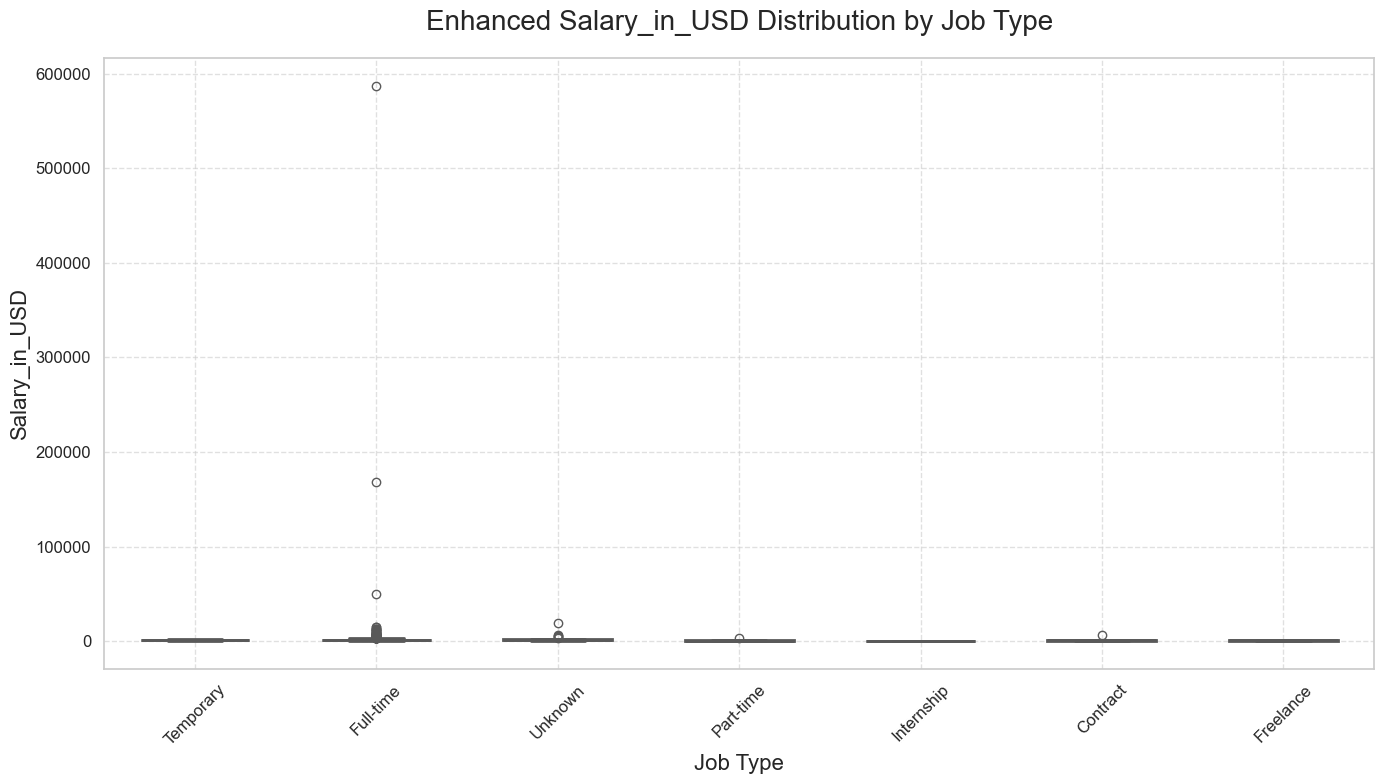

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


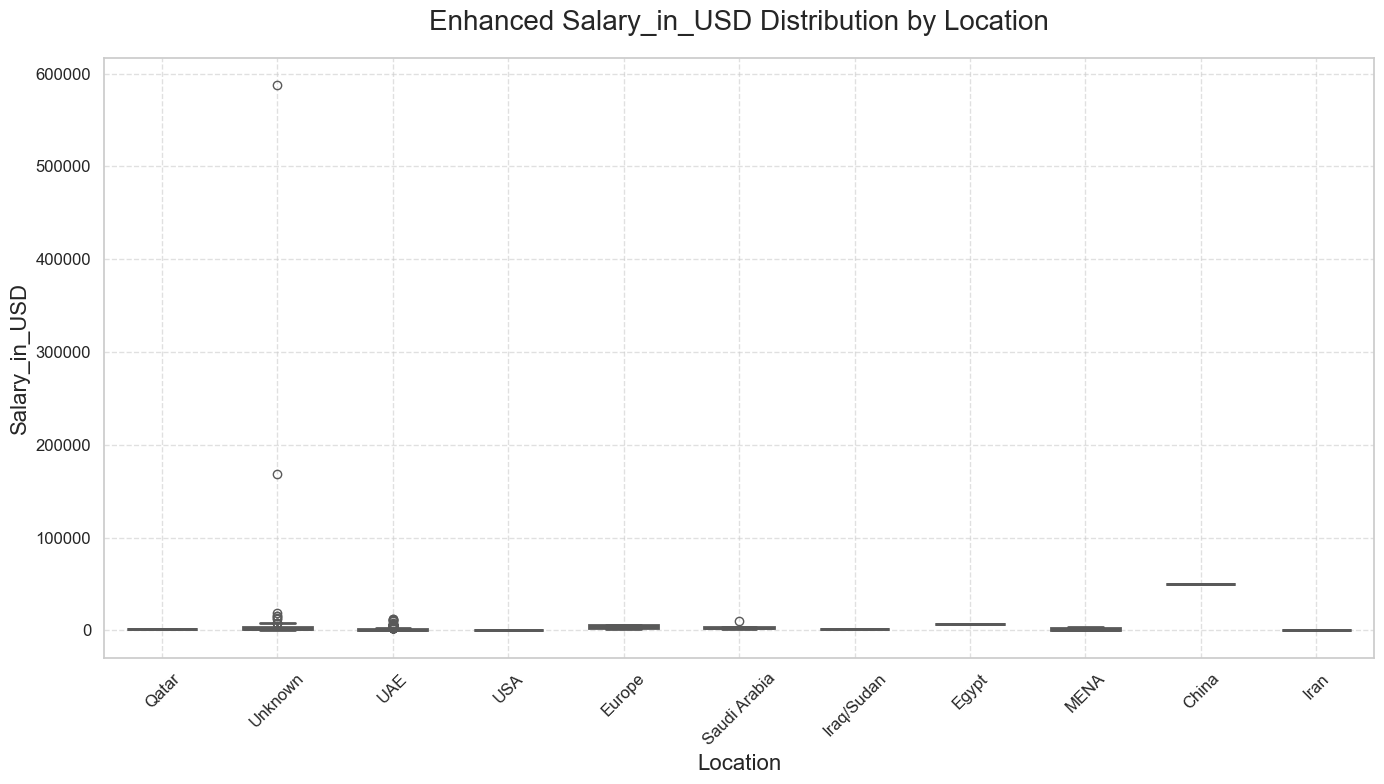

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


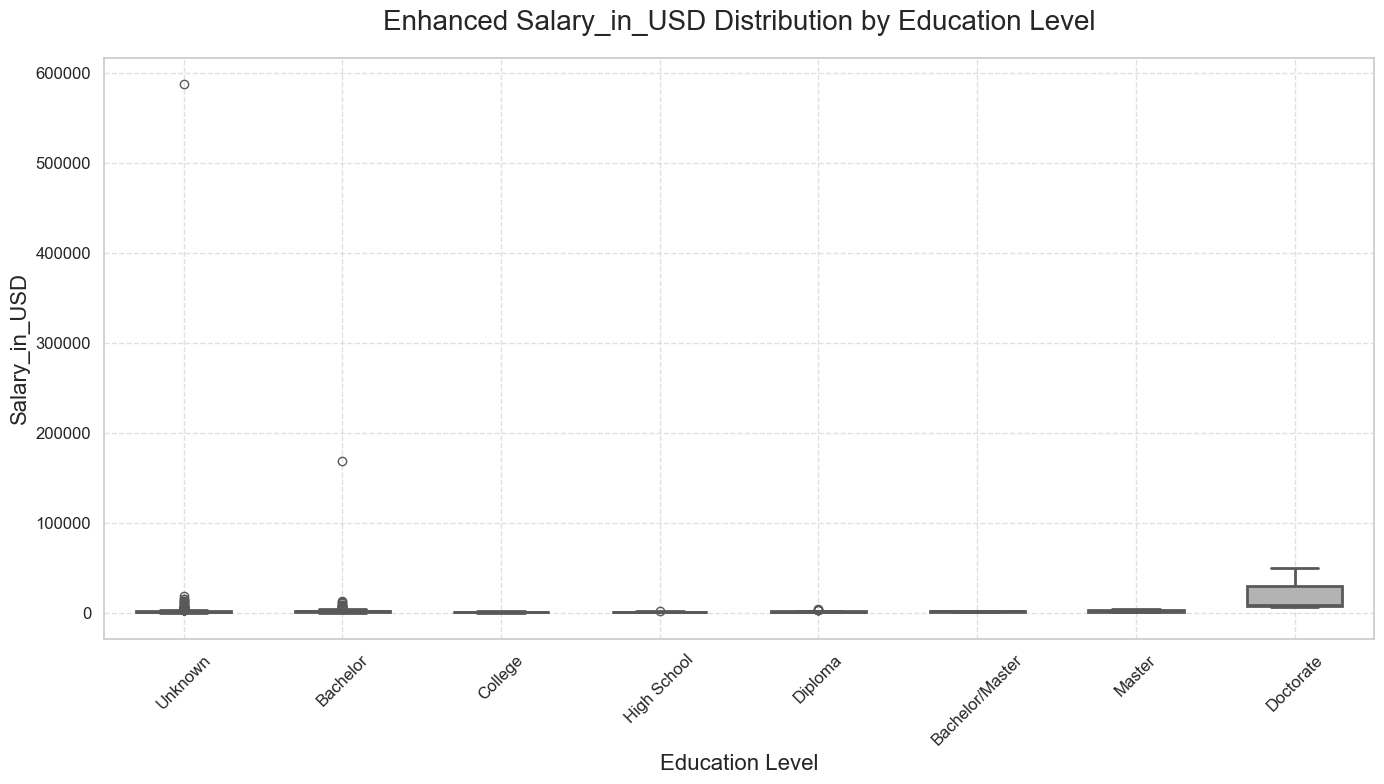

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


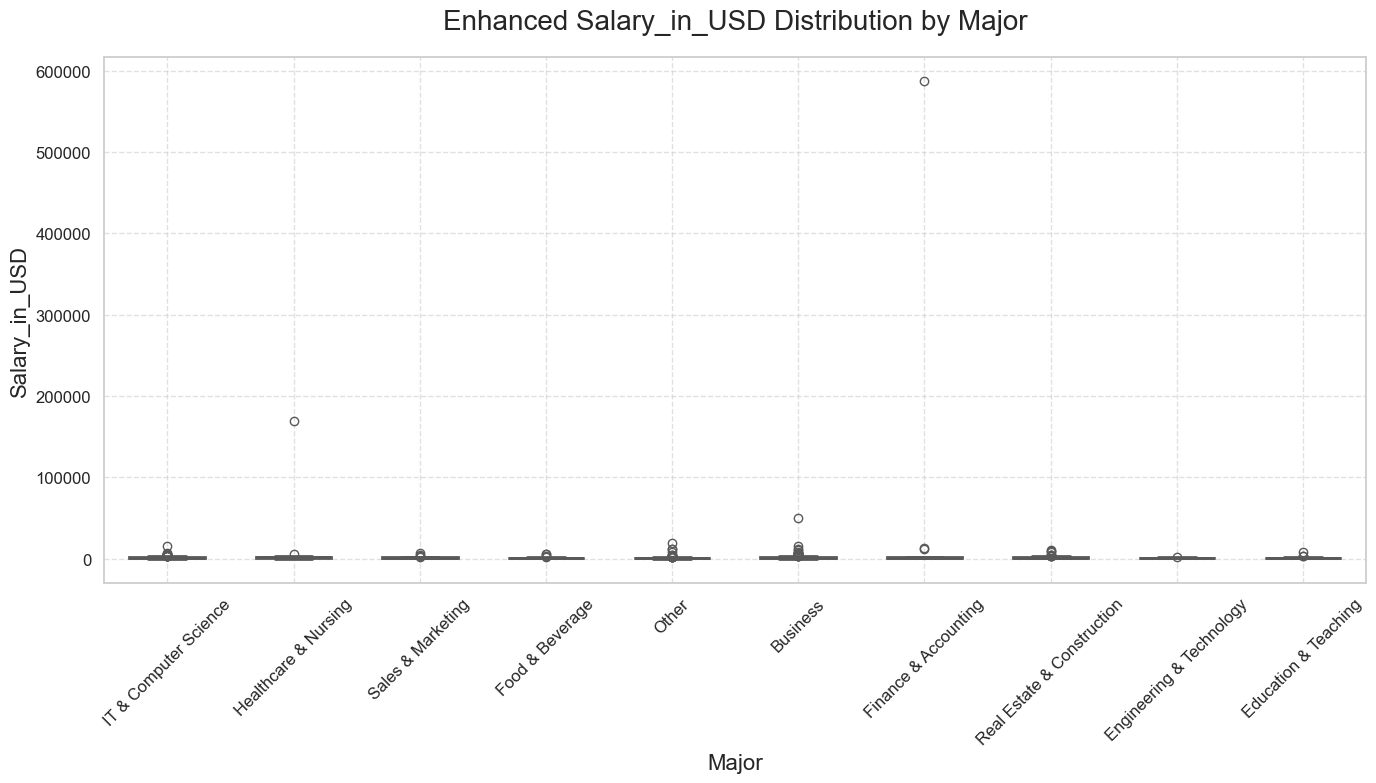

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


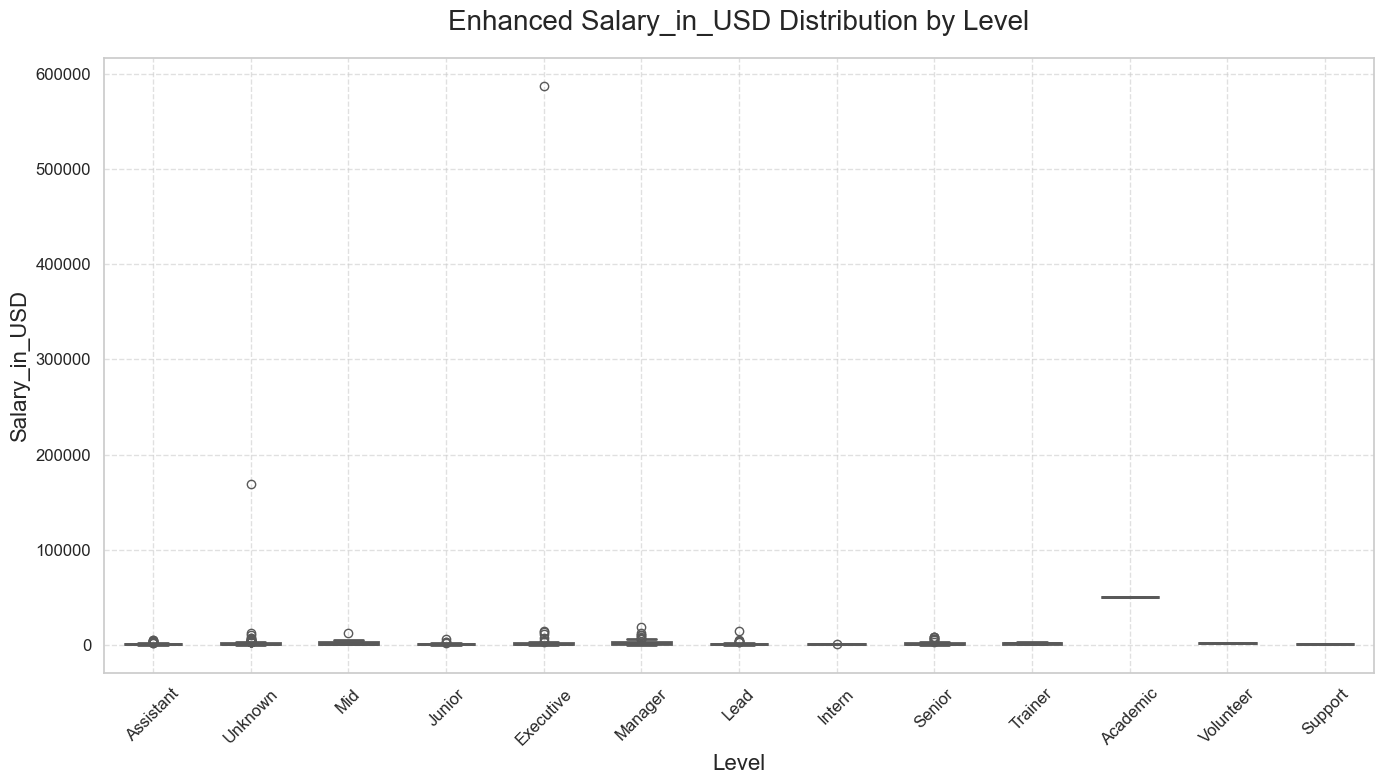

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


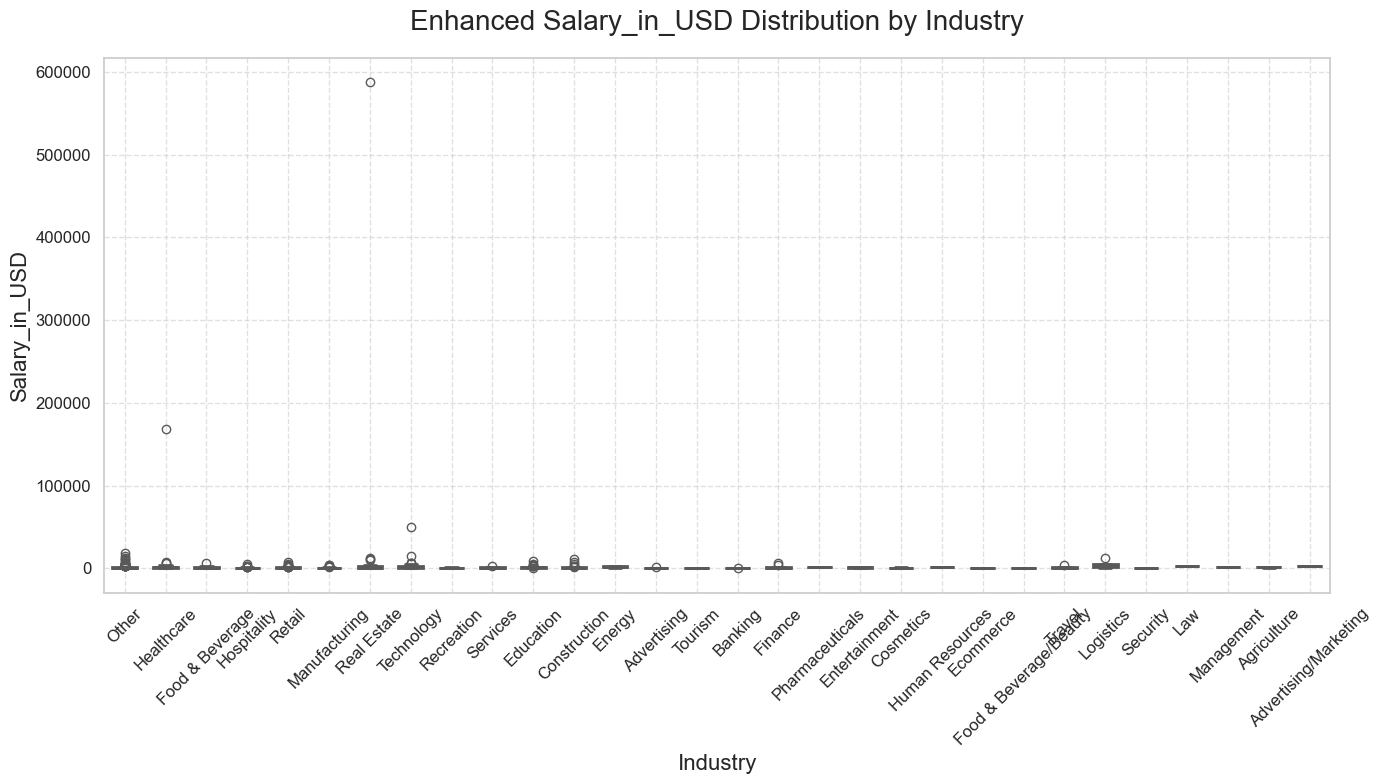

In [10]:
for category in df.select_dtypes('object'):
    plot_categorical_boxplot(df, category_col=category, numeric_col='Salary_in_USD')

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


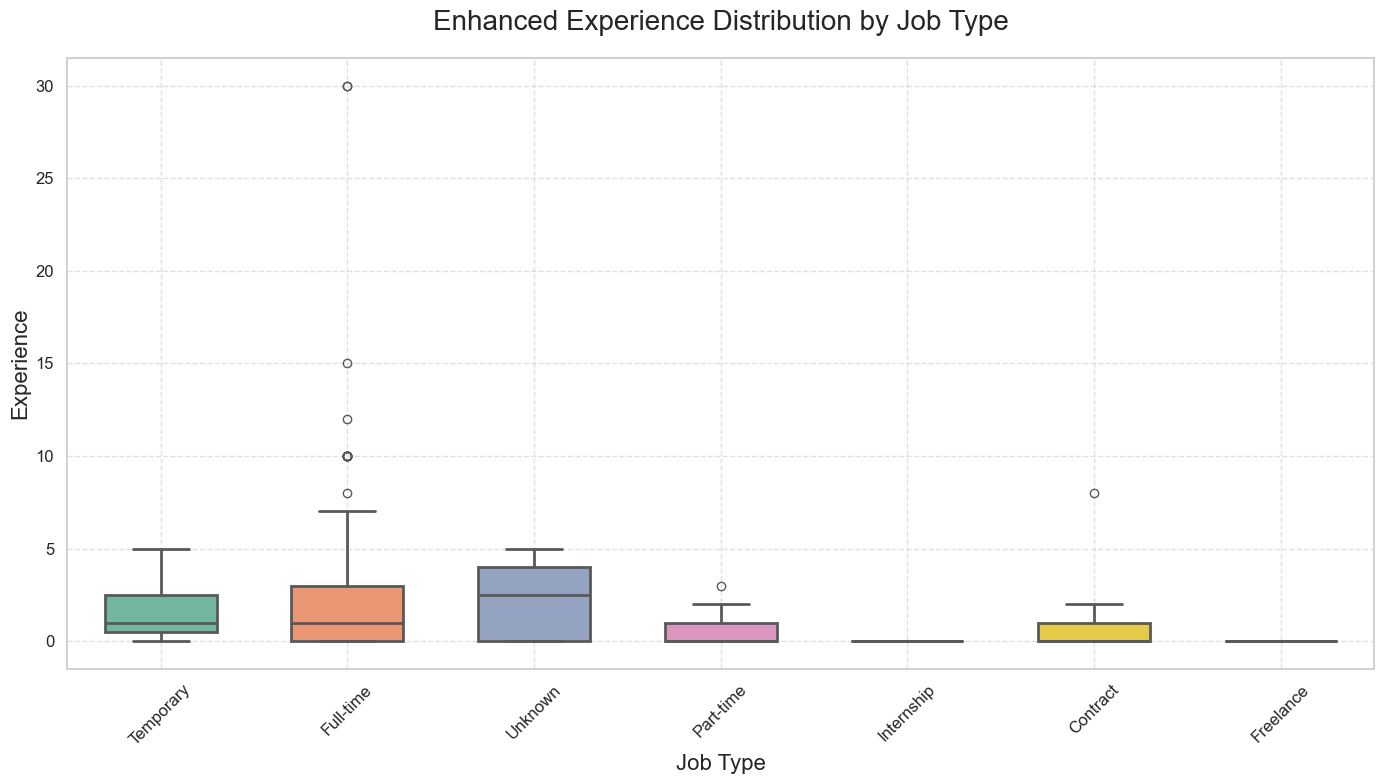

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


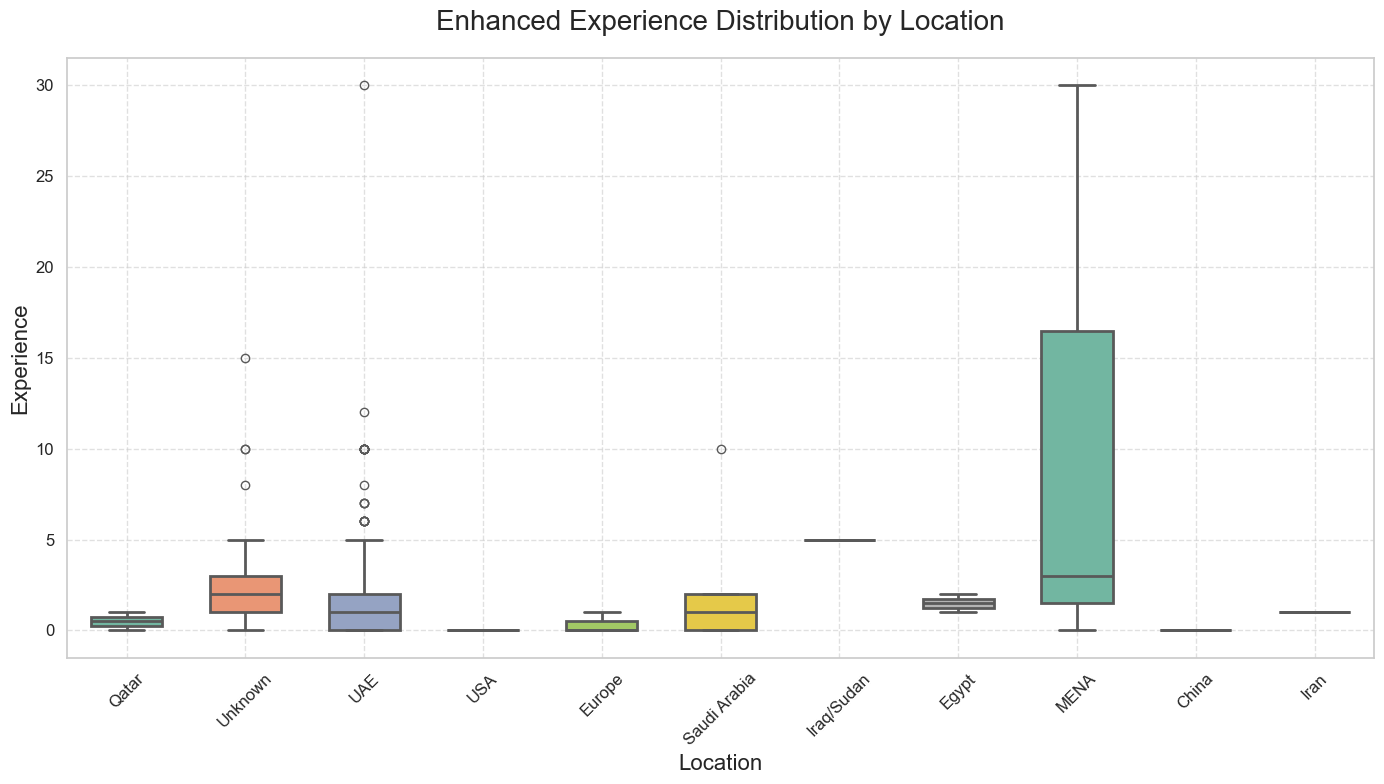

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


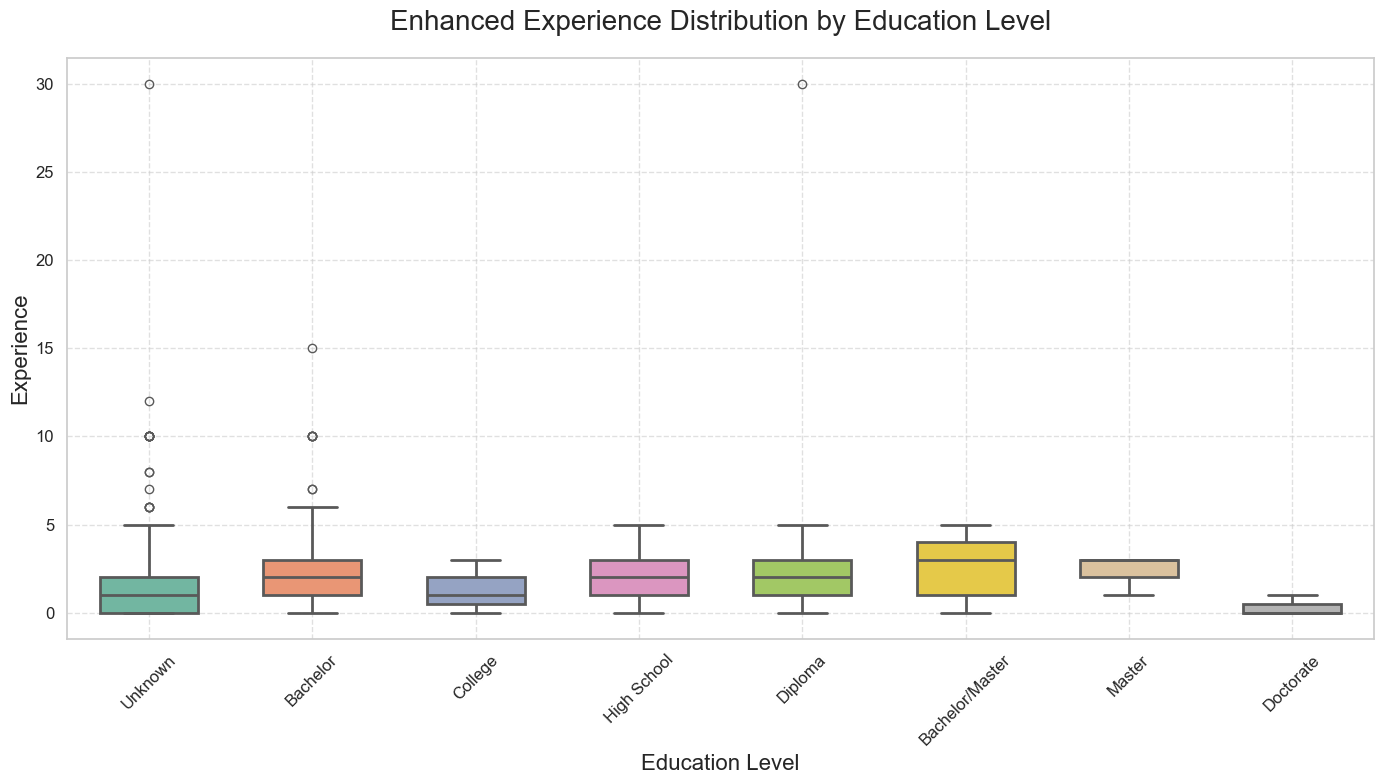

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


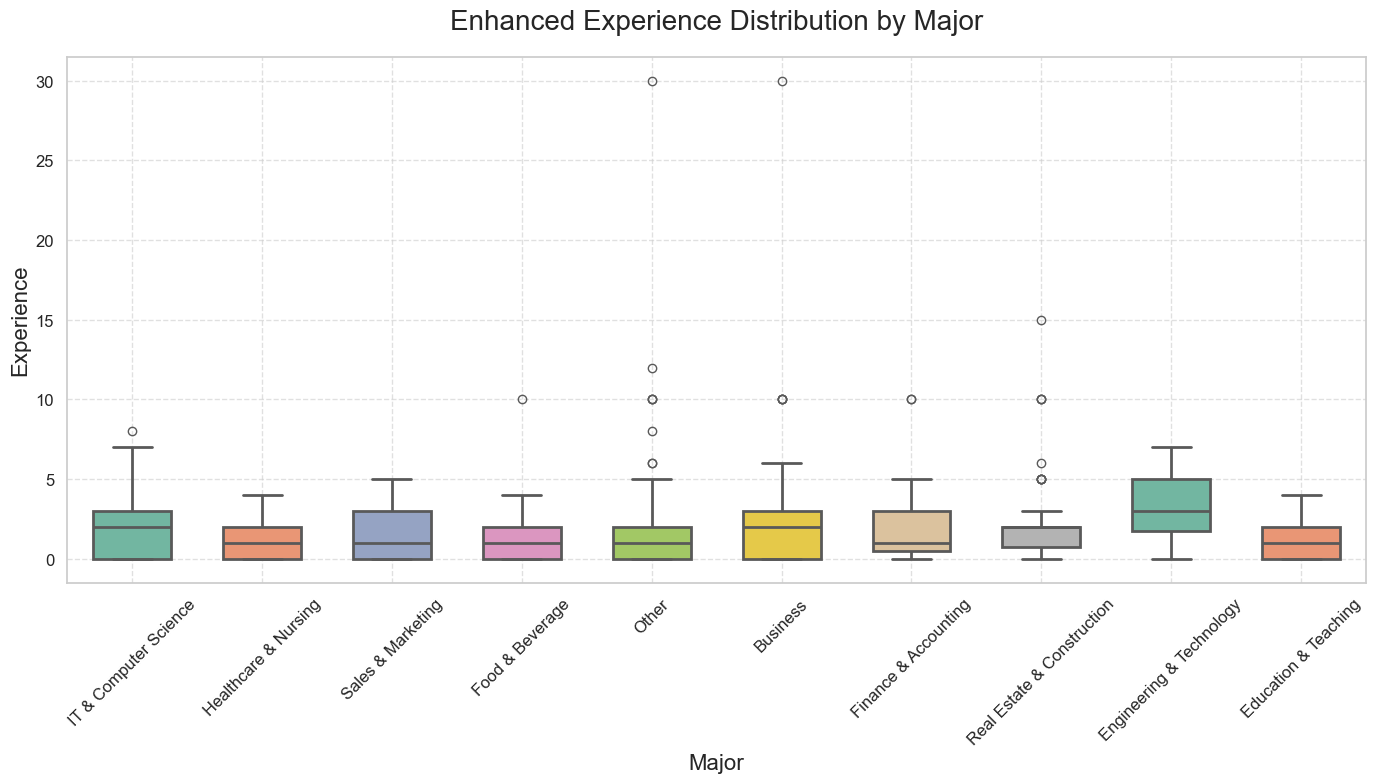

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


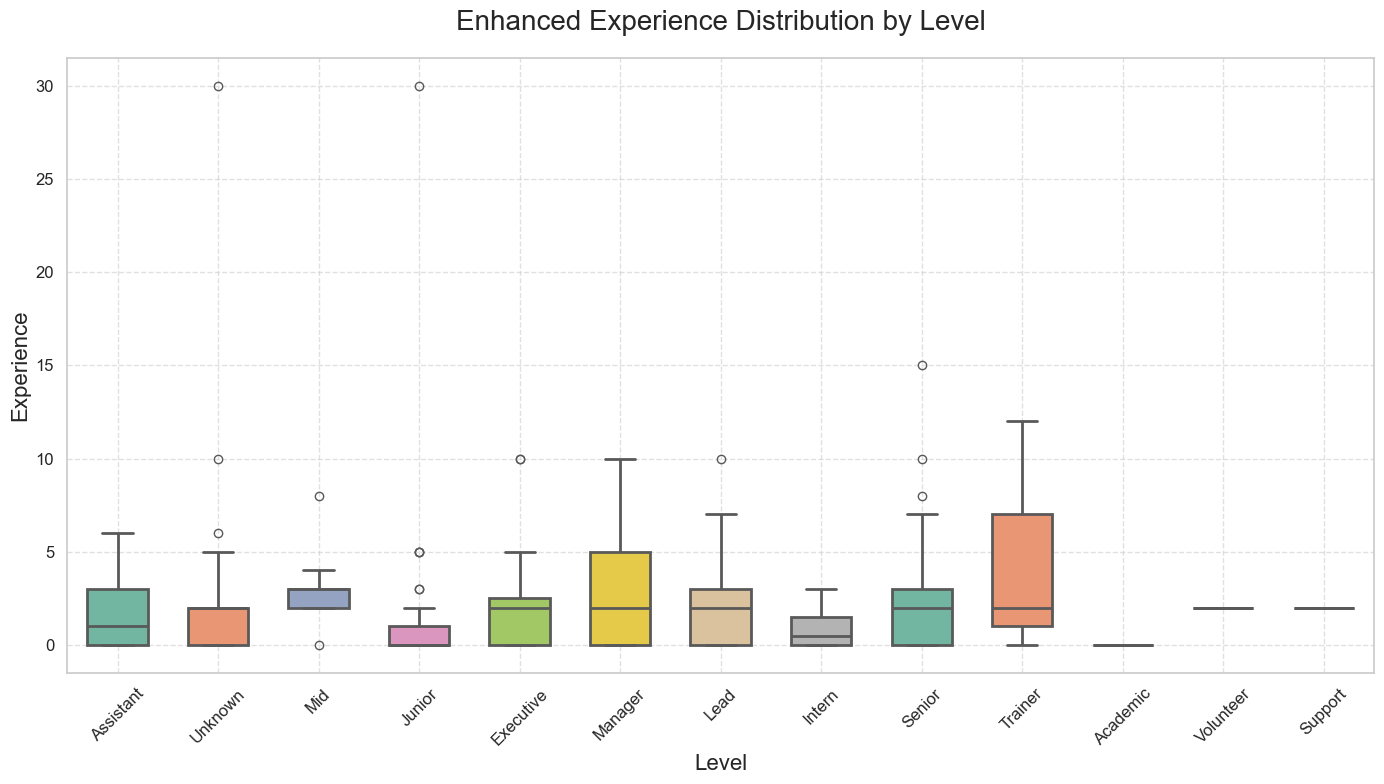

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


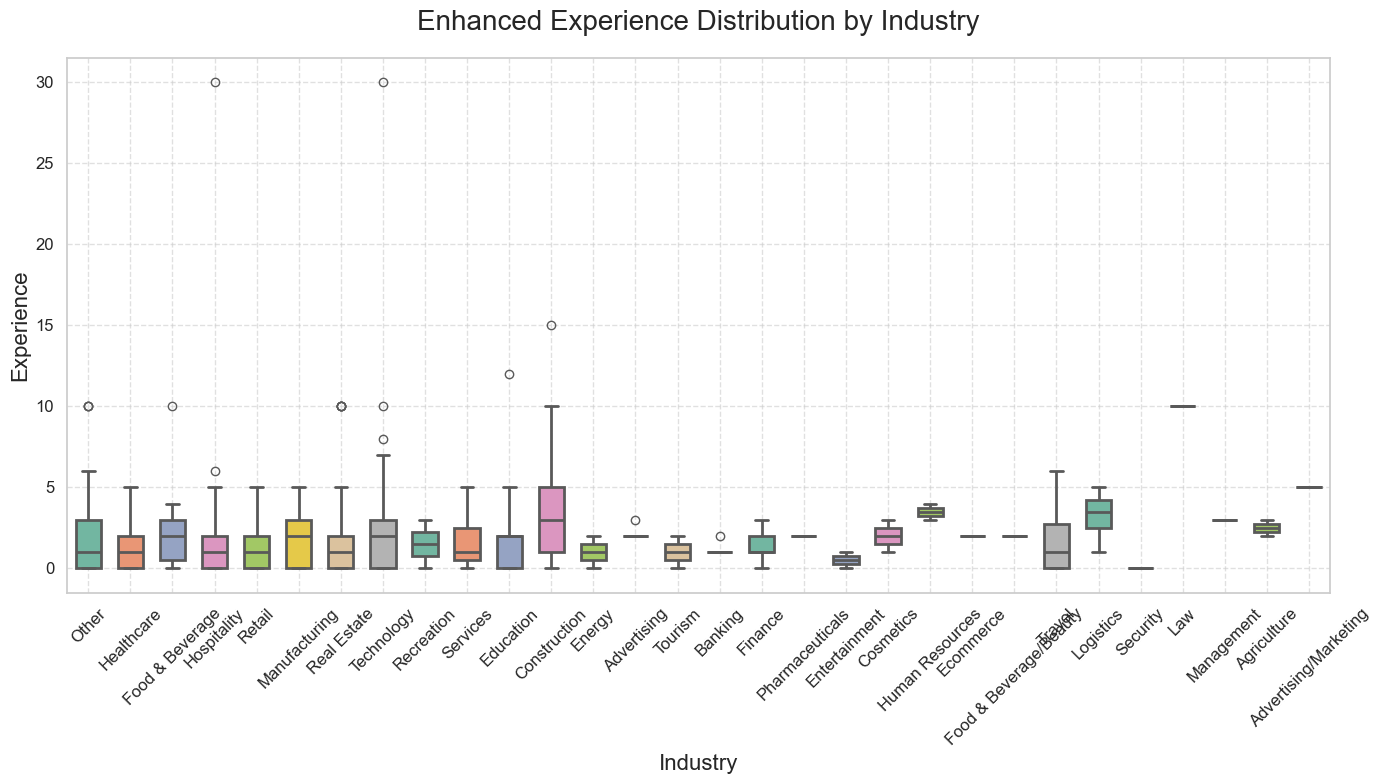

In [11]:
for category in df.select_dtypes('object'):
    plot_categorical_boxplot(df, category_col=category, numeric_col='Experience')

In [12]:
df[df['Salary_in_USD']==587500.000000]

Experience   Job Type Location Education Level                 Major  \
777        10.0  Full-time  Unknown         Unknown  Finance & Accounting   

         Level     Industry  Salary_in_USD  
777  Executive  Real Estate       587500.0

### for the outliers I dont think that theres any need to deal with any one related to the salary in USD because any one can get 58.7500K USD for Executive or Leadership Positions, Entrepreneurship and Business Ownership, High-Paying Professions, Finance Sector, Entertainment and Sports by checking the status f this person I found that he is working in Finance & Accounting sector in Executive role in the Real Estate industry, but about the years of experinces any one also can has 30 years of experince

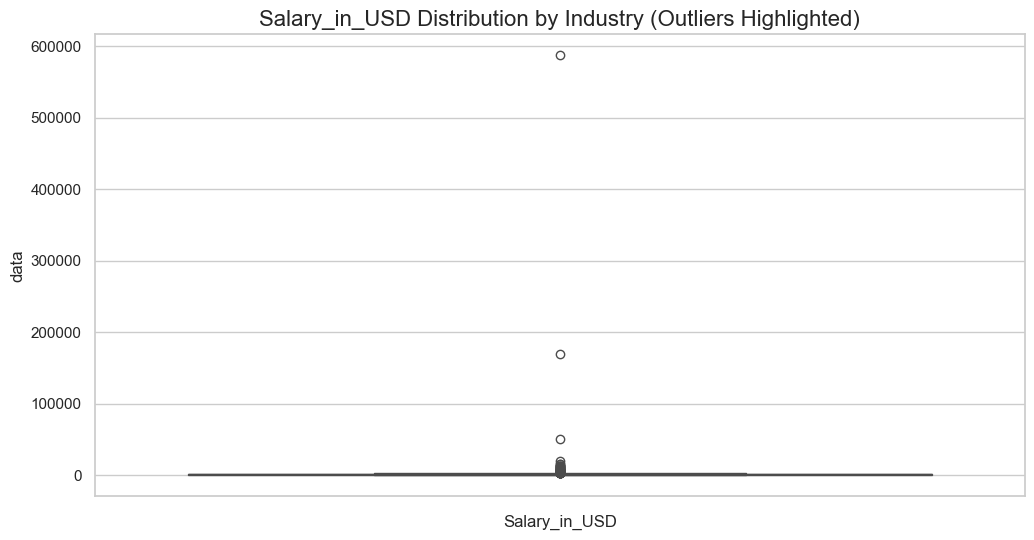

In [13]:
box_plot_for_y(df,'Salary_in_USD')

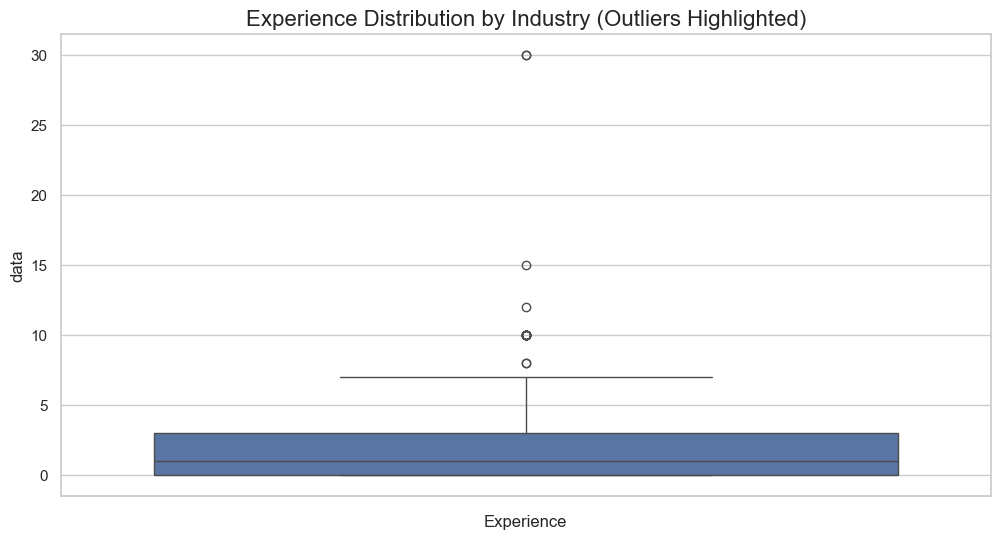

In [14]:
box_plot_for_y(df,'Experience')

An age of **0**  indicate infants

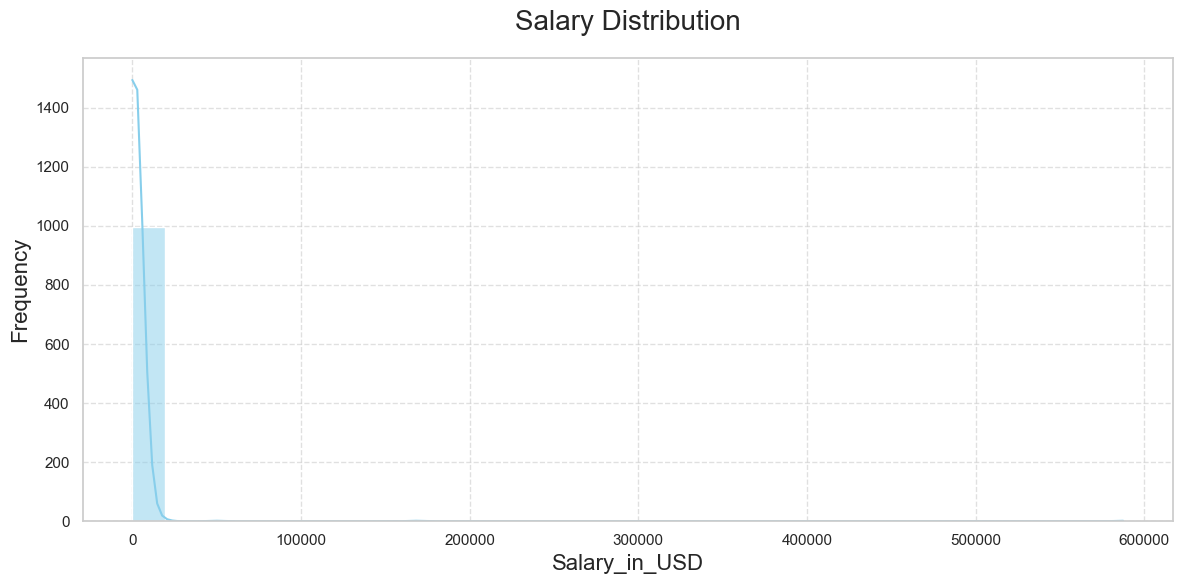

In [15]:
plot_histogram(df, column='Salary_in_USD', title='Salary Distribution')

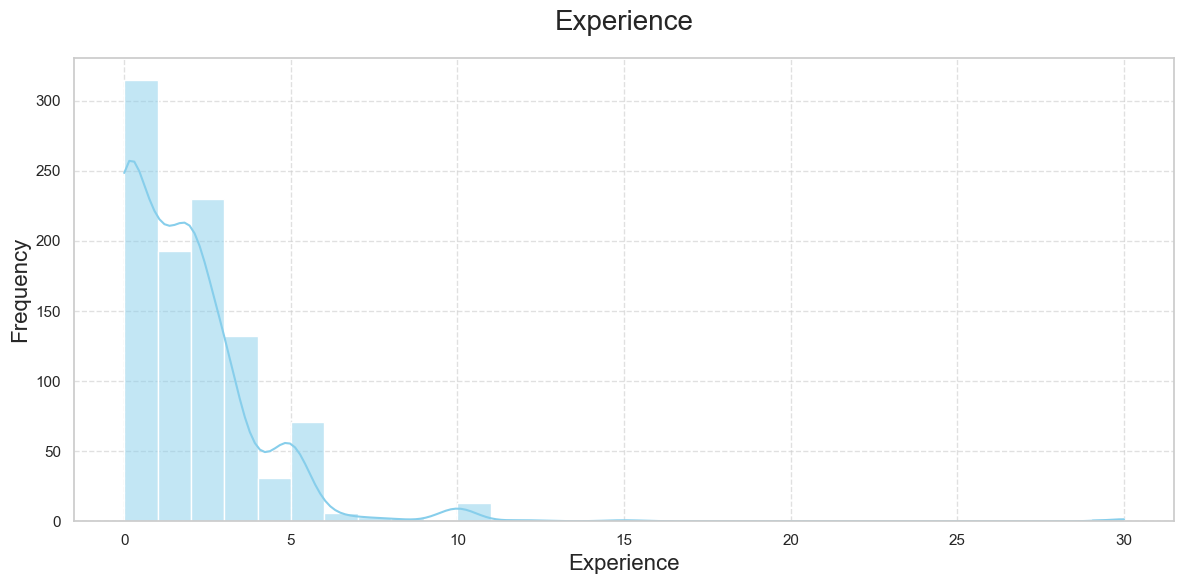

In [16]:
plot_histogram(df, column='Experience', title='Experience')

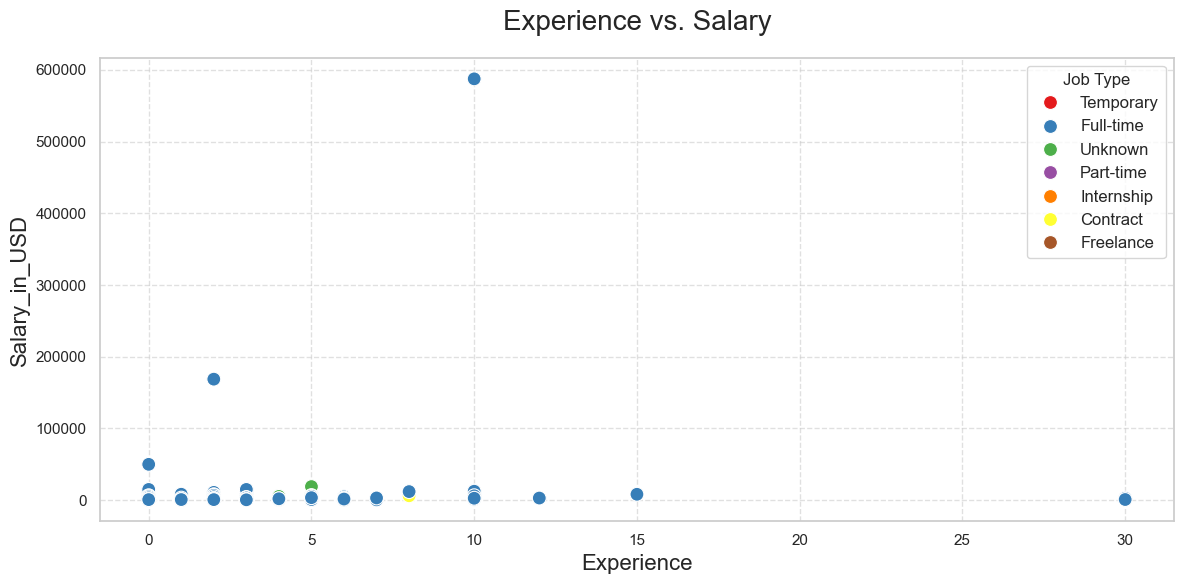

In [17]:
plot_scatter(df, x_col='Experience', y_col='Salary_in_USD', hue='Job Type', title='Experience vs. Salary')

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=x_col, palette='pastel')


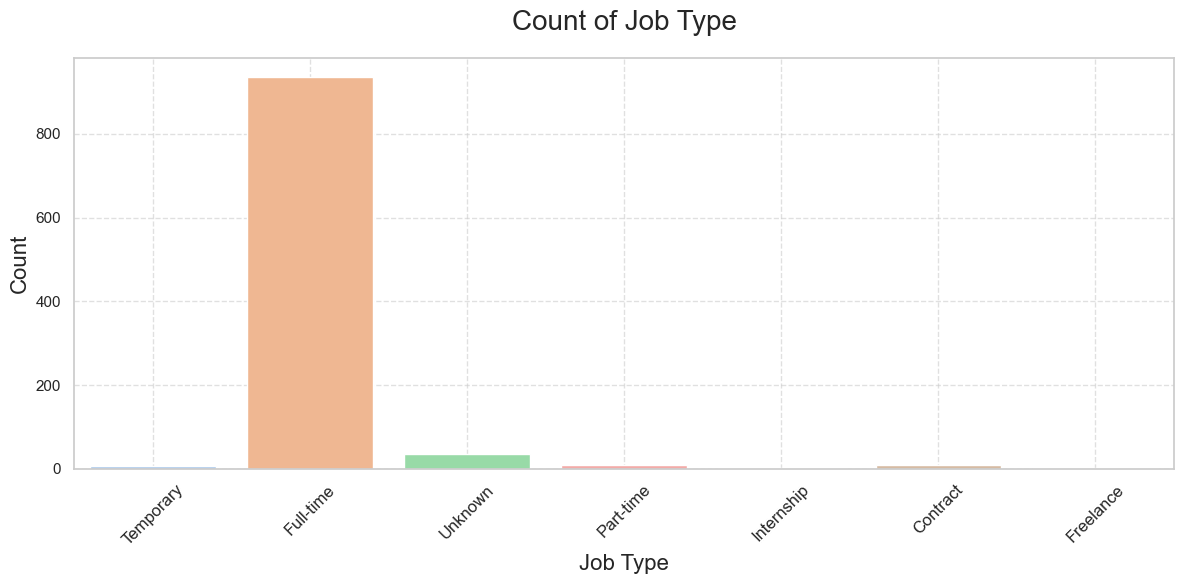

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=x_col, palette='pastel')


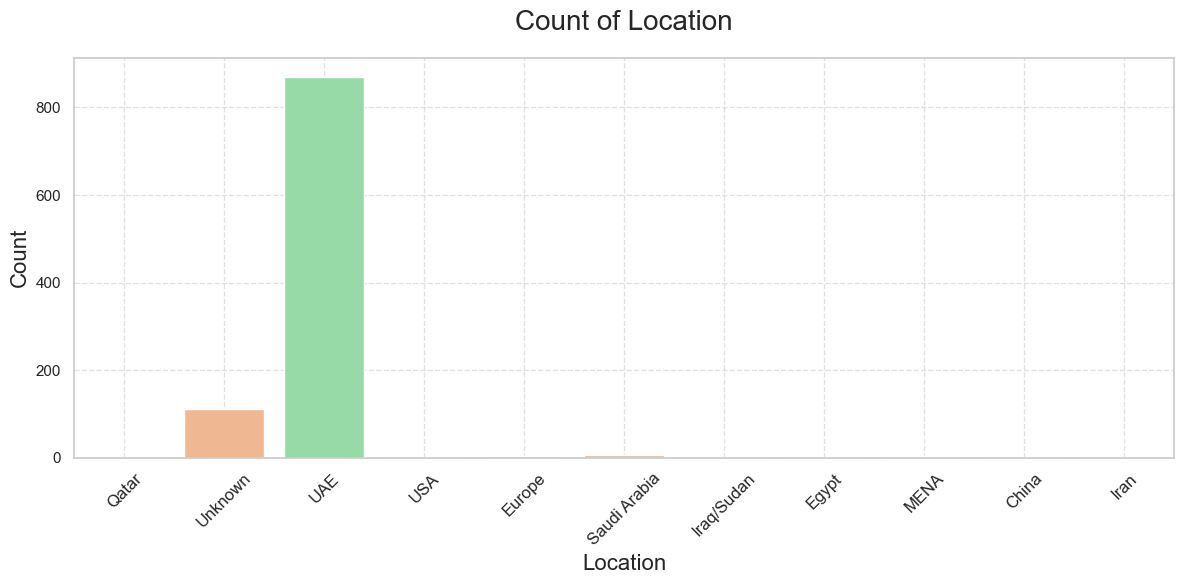

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=x_col, palette='pastel')


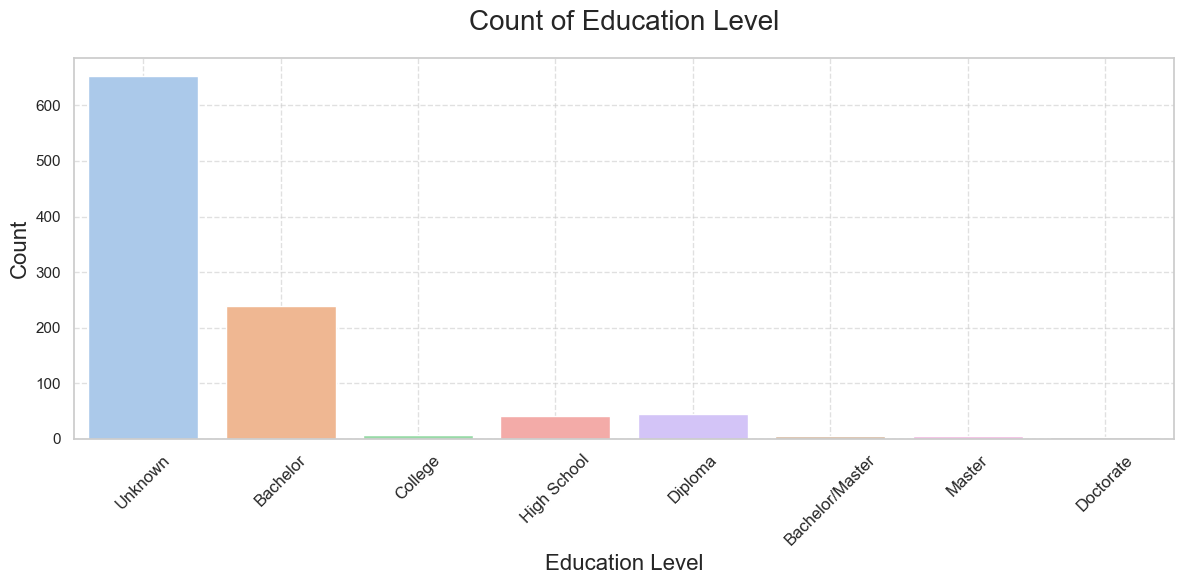

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=x_col, palette='pastel')


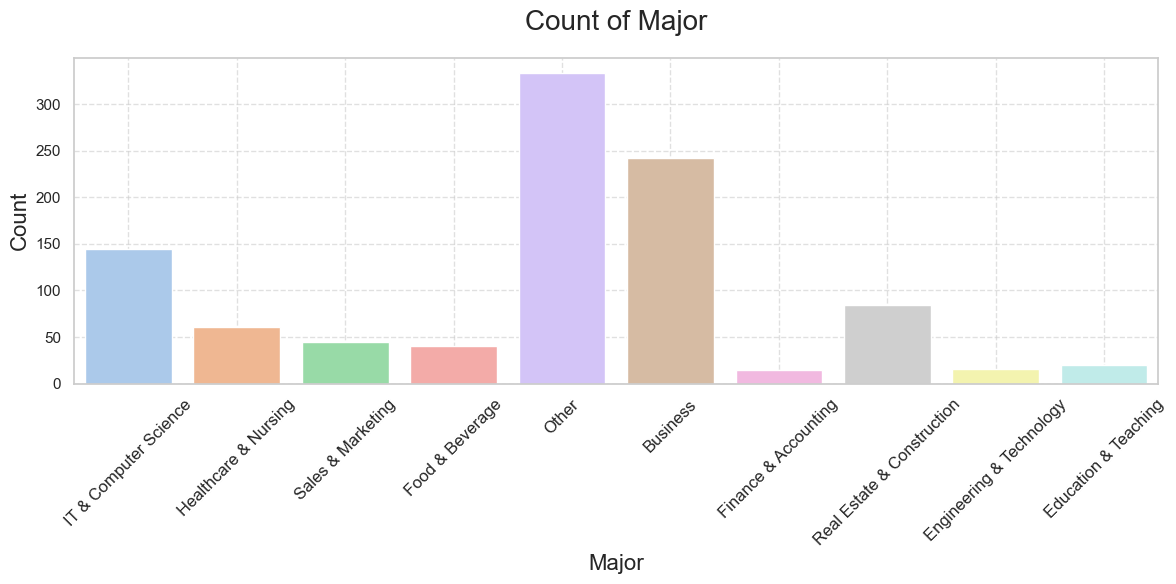

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=x_col, palette='pastel')


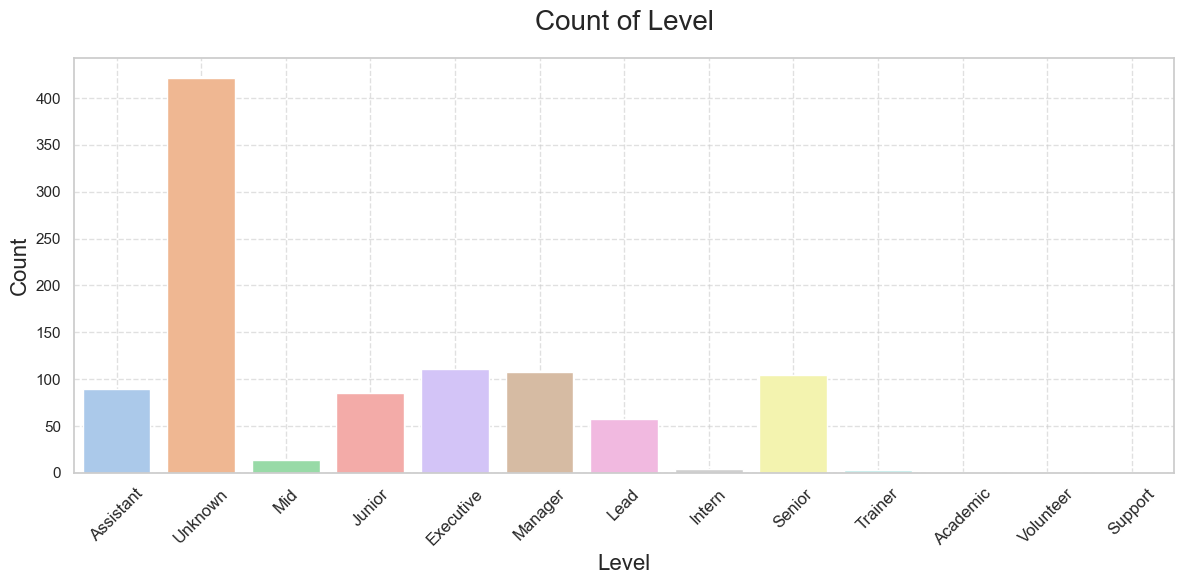

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=x_col, palette='pastel')


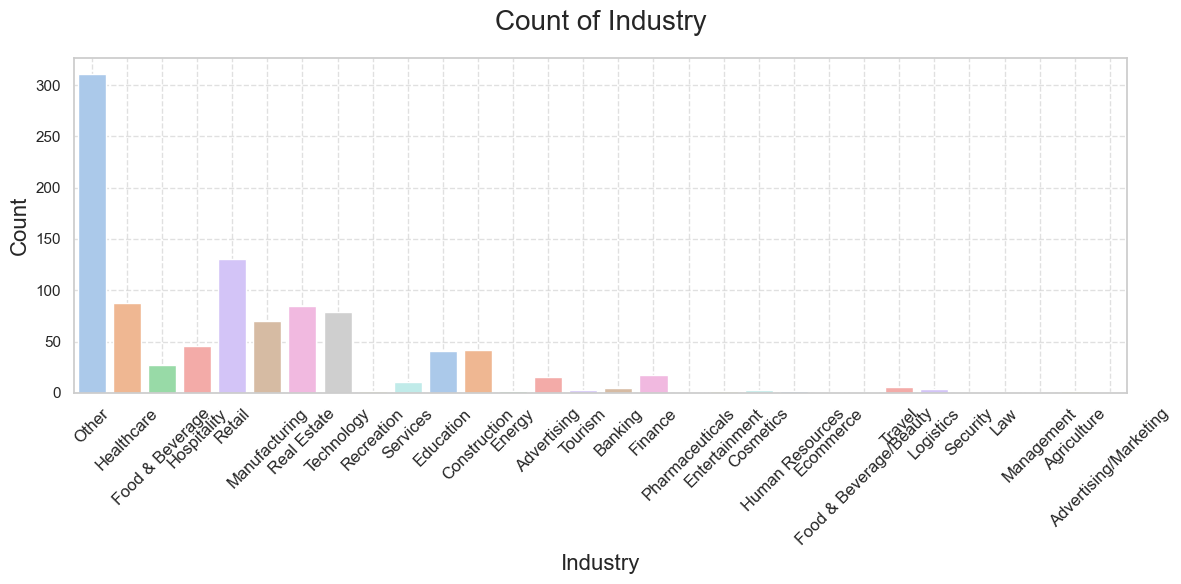

In [18]:
for category in df.select_dtypes('object'):
    plot_bar(df, x_col=category, title=f'Count of {category}')

Most of the people are working on fulltime positions, in UAE, working on retail mostly in Senor, Managers, Exective positions with very high values of Unknown which is very bad!

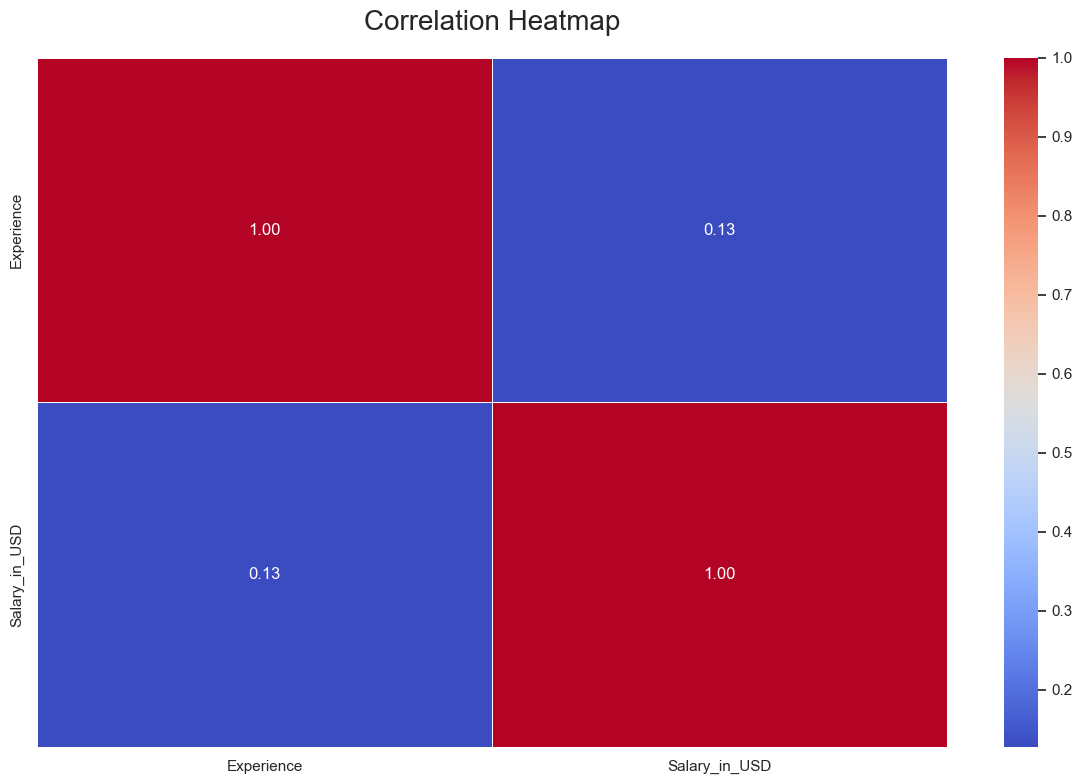

In [19]:
plot_correlation_heatmap(df.select_dtypes('float'), title='Correlation Heatmap')

### Split the data

In [95]:
X = df.drop(columns = ['Salary_in_USD', 'Industry'])
y = df['Salary_in_USD']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Define pipelines for different features : categorical , ordinal and numeric

I will choose Level column, Education Level, Location, Job Type, as an ordinal features

#### PREPROCESSING PIPELINE FOR NUMERIC DATA

In [97]:
num_cols = X_train.select_dtypes("number").columns
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
num_pipe = make_pipeline(impute_median, scaler)
num_tuple = ('numeric', num_pipe, num_cols)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

#### PREPROCESSING FOR CATEGORICAL DATA using ONE-HOT-ENCODED

#### PREPROCESSING FOR ORDINAL DATA

In [98]:
ord_cols = ['Job Type','Location', 'Education Level', 'Level']
Job_Type = ['Unknown', 'Internship', 'Temporary', 'Contract', 'Freelance', 'Part-time', 'Full-time', ]
Location = ['Unknown','Iraq/Sudan', 'Egypt', 'Iran', 'China','MENA', 'UAE', 'Saudi Arabia', 'Qatar', 'Europe', 'USA']
Education_Level = ['Unknown', 'High School', 'Diploma','College', 'Bachelor', 'Bachelor/Master', 'Master', 'Doctorate']
Level = ['Unknown', 'Volunteer','Intern', 'Assistant',  'Support', 'Junior', 'Mid', 'Trainer', 'Senior', 'Lead', 'Academic', 'Manager','Executive'    ]
ordinal_category_orders = [Job_Type, Location, Education_Level, Level]

impute_na_ord = SimpleImputer(strategy='constant', fill_value='Unknown')

ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
scaler_ord = StandardScaler()
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_encoder

OrdinalEncoder(categories=[['Unknown', 'Internship', 'Temporary', 'Contract',
                            'Freelance', 'Part-time', 'Full-time'],
                           ['Unknown', 'Iraq/Sudan', 'Egypt', 'Iran', 'China',
                            'MENA', 'UAE', 'Saudi Arabia', 'Qatar', 'Europe',
                            'USA'],
                           ['Unknown', 'High School', 'Diploma', 'College',
                            'Bachelor', 'Bachelor/Master', 'Master',
                            'Doctorate'],
                           ['Unknown', 'Volunteer', 'Intern', 'Assistant',
                            'Support', 'Junior', 'Mid', 'Trainer', 'Senior',
                            'Lead', 'Academic', 'Manager', 'Executive']])

In [99]:
ohe_cols = ['Major']
print(ohe_cols)
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_tuple = ('categorical', ohe_encoder, ohe_cols)
ohe_encoder

['Major']


OneHotEncoder(handle_unknown='ignore', sparse_output=False)

#### Instantiate with verbose_feature_names_out=False

In [100]:
col_transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple], verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Experience'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Unknown',
                                                                              'Intern...
                                                                              'Doctorate'],
                                                                             ['Unknown',
                                                                              'Volunteer',
                                                                              'Intern',
                                                                              'Assistant',
                                                                              'Support',
                                                                              'Junior',
                                                                              'Mid',
                                                                              'Trainer',
                                                                              'Senior',
                                                                              'Lead',
                                                                              'Academic',
                                                                              'Manager',
                                                                              'Executive']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Job Type', 'Location', 'Education Level',
                                  'Level']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Major'])],
                  verbose_feature_names_out=False)

In [101]:
X_train_processed = col_transformer.fit_transform(X_train)
X_test_processed = col_transformer.transform(X_test)

#### Build and fit a model pipeline with the preprocessor and a default Instantiate bagging regressor 

In [102]:
bgr = BaggingRegressor(random_state=42)
bgr_pipe = make_pipeline(col_transformer, bgr)
bgr_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Experience'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalE...
                                                                                               'Support',
                                                                                               'Junior',
                                                                                               'Mid',
                                                                                               'Trainer',
                                                                                               'Senior',
                                                                                               'Lead',
                                                                                               'Academic',
                                                                                               'Manager',
                                                                                               'Executive']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Job Type', 'Location',
                                                   'Education Level',
                                                   'Level']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Major'])],
                                   verbose_feature_names_out=False)),
                ('baggingregressor', BaggingRegressor(random_state=42))])

#### Fit the model pipeline on the training data

In [103]:
bgr_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Experience'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalE...
                                                                                               'Support',
                                                                                               'Junior',
                                                                                               'Mid',
                                                                                               'Trainer',
                                                                                               'Senior',
                                                                                               'Lead',
                                                                                               'Academic',
                                                                                               'Manager',
                                                                                               'Executive']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Job Type', 'Location',
                                                   'Education Level',
                                                   'Level']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Major'])],
                                   verbose_feature_names_out=False)),
                ('baggingregressor', BaggingRegressor(random_state=42))])

In [104]:
evaluate_regression(bgr_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 802.793
- MSE = 45,438,010.721
- RMSE = 6,740.772
- R^2 = 0.902

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 3,466.723
- MSE = 771,394,437.913
- RMSE = 27,773.989
- R^2 = -5.716


**Poor quality**

### High overfit, we need to do some actions like hyperparmeters tunuing and try other models

In [106]:
bgr = BaggingRegressor(random_state=42)
bgr.get_params()

{'bootstrap': True,
 'bootstrap_features': False,
 'estimator': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [107]:
pg = {
    'bootstrap': [True, False], 
    'bootstrap_features': [True, False], 
    'n_estimators': [5, 10, 20, 30, 40, 50],
    'max_samples' : [.5, .7, .9,],
    'max_features': [.5, .7, .9],
    'n_jobs': [2, 3, 4, 5], 
    'oob_score': [True, False], 
    'verbose': [0, 1, 2, 3],
    'warm_start': [True, False], 
    }

gs = GridSearchCV(bgr, param_grid=pg, cv=5)
gs.fit(X_train_processed, y_train)

GridSearchCV(cv=5, estimator=BaggingRegressor(random_state=42),
             param_grid={'max_features': [0.5, 0.7, 0.9],
                         'max_samples': [0.5, 0.7, 0.9],
                         'n_estimators': [5, 10, 20, 30, 40, 50]})

In [108]:
best_bagged_tree = gs.best_estimator_
best_bagged_tree

BaggingRegressor(max_features=0.5, max_samples=0.7, n_estimators=50,
                 random_state=42)

In [109]:
evaluate_regression(best_bagged_tree, X_train_processed, y_train, X_test_processed, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 1,447.260
- MSE = 213,143,606.944
- RMSE = 14,599.439
- R^2 = 0.540

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 2,598.928
- MSE = 259,305,250.527
- RMSE = 16,102.958
- R^2 = -1.257


**Poor quality**

#### Lets try the Random Forest Regressor

In [110]:
rf = RandomForestRegressor(random_state=42)
rf_pipe = make_pipeline(col_transformer, rf)
rf_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Experience'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalE...
                                                                                               'Junior',
                                                                                               'Mid',
                                                                                               'Trainer',
                                                                                               'Senior',
                                                                                               'Lead',
                                                                                               'Academic',
                                                                                               'Manager',
                                                                                               'Executive']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Job Type', 'Location',
                                                   'Education Level',
                                                   'Level']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Major'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [111]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Experience'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalE...
                                                                                               'Junior',
                                                                                               'Mid',
                                                                                               'Trainer',
                                                                                               'Senior',
                                                                                               'Lead',
                                                                                               'Academic',
                                                                                               'Manager',
                                                                                               'Executive']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Job Type', 'Location',
                                                   'Education Level',
                                                   'Level']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Major'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [112]:
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 974.482
- MSE = 85,094,261.073
- RMSE = 9,224.655
- R^2 = 0.816

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 3,077.395
- MSE = 569,805,240.243
- RMSE = 23,870.594
- R^2 = -3.961


**Poor quality**

#### High overfit, we need to do some actions like hyperparmeters tunuing and try other models

In [113]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [114]:
params = {
 'bootstrap': [True, False],
 'ccp_alpha': [0.1,0.25,0.5,0.75],
 'max_depth': [None,10,15,20],
 'min_samples_leaf':[2,3,4],
 'min_samples_split': [2,3,4],
 'n_estimators': [10,100,150,200],
 'n_jobs': [2, 3, 4, 5],
 'oob_score': [True, False],
 'verbose': [0, 1, 2, 3],
 'warm_start': [True, False] 
}
gs = GridSearchCV(rf, param_grid=params, cv=5)
gs.fit(X_train_processed, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 15, 20],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 3, 4]})

In [115]:
best_tree = gs.best_estimator_
best_tree

RandomForestRegressor(bootstrap=False, max_depth=15, min_samples_leaf=2,
                      random_state=42)

In [116]:
evaluate_regression(best_tree, X_train_processed, y_train, X_test_processed, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 1,379.710
- MSE = 223,586,766.089
- RMSE = 14,952.818
- R^2 = 0.517

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 2,700.049
- MSE = 440,845,693.855
- RMSE = 20,996.326
- R^2 = -2.838


**Poor quality**

## Try deep learning

In [117]:
def create_regression_model(input_dim):
    model = Sequential(name="Deep_Regression_Model")
    model.add(layers.Dense(128, activation='relu', input_dim=input_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))  
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(1))
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='mse', 
                  metrics=['mae'])  
    
    model.summary()
    return model

In [118]:
def create_regression_model(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='mse',  
        metrics=['mae']  
    )
    
    model.summary()
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

X_train_processed = X_train_processed.values if hasattr(X_train_processed, 'values') else X_train_processed
y_train = y_train.values if hasattr(y_train, 'values') else y_train

if len(X_train_processed.shape) != 2:
    X_train_processed = X_train_processed.reshape(X_train_processed.shape[0], -1)

input_dim = X_train_processed.shape[1]

regression_model = create_regression_model(input_dim)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 128)               2048      
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 1)                 33        
                                                                 
Total params: 12417 (48.50 KB)
Trainable params: 12417 (48.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [119]:
evaluate_regression(regression_model, X_train_processed, y_train, X_test_processed, y_test)

24/24 [==============================] - 0s 843us/step
------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 2,323.638
- MSE = 468,345,065.371
- RMSE = 21,641.282
- R^2 = -0.012

8/8 [==============================] - 0s 887us/step
------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 2,189.478
- MSE = 119,658,493.015
- RMSE = 10,938.852
- R^2 = -0.042


**Poor quality**

In [127]:
def create_enhanced_regression_model(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,), kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),  

        # Hidden layer 1
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),

        # Hidden layer 2
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),

        # Output layer
        layers.Dense(1)  
    ])

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='mse', 
        metrics=['mae']  
    )
    
    model.summary()
    return model


In [121]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

enhanced_model = create_enhanced_regression_model(input_dim)

history = enhanced_model.fit(
    X_train_processed, y_train,
    validation_split=0.2,  
    epochs=100,  
    batch_size=32,  
    callbacks=[early_stop],  
    verbose=1
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 128)               2048      
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_32 (Dense)            (None, 1)                

In [122]:
evaluate_regression(enhanced_model, X_train_processed, y_train, X_test_processed, y_test)

24/24 [==============================] - 0s 830us/step
------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 1,853.963
- MSE = 457,844,905.361
- RMSE = 21,397.311
- R^2 = 0.011

8/8 [==============================] - 0s 1ms/step
------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 1,802.305
- MSE = 113,338,259.830
- RMSE = 10,646.044
- R^2 = 0.013


In [125]:
df['Salary_in_USD'].describe()

count      1000.000000
mean       2290.354332
std       19398.610667
min          14.850136
25%         681.198910
50%         991.668413
75%        1634.877384
max      587500.000000
Name: Salary_in_USD, dtype: float64

###  **Model Metrics**

#### **Training Data**
- **MAE (Mean Absolute Error):** \(1,853.96\)
  - The model predictions differ from the actual values by \(1,853.96\) units.
  - Mean salary (\(2,290.35\)), this is a significant error, indicating low accuracy.
  
- **MSE (Mean Squared Error):** \(457,844,905.36\)
  - A large error due to squaring residuals.

- **RMSE (Root Mean Squared Error):** \(21,397.31\)
  - The standard deviation of prediction errors higher than the mean salary (\(2,290.35\)), the model struggles with variance.

- **\(R^2\) (Coefficient of Determination):** \(0.011\)
  - The model explains only **1.1% of the variance** in the training data, which is very bad.

---

#### **Test Data**
- **MAE (Mean Absolute Error):** \(1,802.31\)
  - Similar error to the training data, no overfitting but its underperformance.

- **MSE (Mean Squared Error):** \(113,338,259.83\)
  - High value, indicating large errors.

- **RMSE (Root Mean Squared Error):** \(10,646.04\)
  - The standard deviation of prediction errors higher than the mean salary (\(2,290.35\)), the model struggles with variance.

- **\(R^2\):** \(0.013\)
  - The model explains only **1.3% of the variance** in the test data.


## This mean this isnt effcient for this task.

**Solution**:
We need to get more data, process it and try to use another modling techniques

# Using another dataset from the internet:

In [79]:
new_df = pd.read_csv('data/Salary_Data.csv')
new_df

Age  Gender    Education Level              Job Title  \
0     32.0    Male         Bachelor's      Software Engineer   
1     28.0  Female           Master's           Data Analyst   
2     45.0    Male                PhD         Senior Manager   
3     36.0  Female         Bachelor's        Sales Associate   
4     52.0    Male           Master's               Director   
...    ...     ...                ...                    ...   
6699  49.0  Female                PhD  Director of Marketing   
6700  32.0    Male        High School        Sales Associate   
6701  30.0  Female  Bachelor's Degree      Financial Manager   
6702  46.0    Male    Master's Degree      Marketing Manager   
6703  26.0  Female        High School        Sales Executive   

      Years of Experience    Salary  
0                     5.0   90000.0  
1                     3.0   65000.0  
2                    15.0  150000.0  
3                     7.0   60000.0  
4                    20.0  200000.0  
...                   ...       ...  
6699                 20.0  200000.0  
6700                  3.0   50000.0  
6701                  4.0   55000.0  
6702                 14.0  140000.0  
6703                  1.0   35000.0  

[6704 rows x 6 columns]

In [80]:
def assign_job_level(title):
    title = title.lower() if isinstance(title, str) else ""
    if "senior" in title or "principal" in title or "chief" in title:
        return "Senior"
    elif "junior" in title:
        return "Junior"
    elif "manager" in title or "director" in title or "vp" in title:
        return "Manager"
    else:
        return "Other"

def assign_job_sector(title):
    title = title.lower() if isinstance(title, str) else ""
    if any(keyword in title for keyword in ["software", "engineer", "developer", "it", "data", "scientist"]):
        return "Engineering & Technology"
    elif any(keyword in title for keyword in ["sales", "marketing", "advertising", "social media"]):
        return "Marketing & Sales"
    elif any(keyword in title for keyword in ["finance", "accountant", "hr", "human resources"]):
        return "Finance & HR"
    elif any(keyword in title for keyword in ["operations", "project", "customer service", "support"]):
        return "Operations & Support"
    elif any(keyword in title for keyword in ["design", "creative", "writer", "content"]):
        return "Creative & Design"
    else:
        return "Miscellaneous"

In [81]:
new_df.describe()

Age  Years of Experience         Salary
count  6702.000000          6701.000000    6699.000000
mean     33.620859             8.094687  115326.964771
std       7.614633             6.059003   52786.183911
min      21.000000             0.000000     350.000000
25%      28.000000             3.000000   70000.000000
50%      32.000000             7.000000  115000.000000
75%      38.000000            12.000000  160000.000000
max      62.000000            34.000000  250000.000000

In [82]:
new_df.nunique() / len(new_df) *100

Age                    0.611575
Gender                 0.044749
Education Level        0.104415
Job Title              2.878878
Years of Experience    0.551909
Salary                 6.622912
dtype: float64

In [83]:
for col in new_df.select_dtypes("object"):
  print(f"{col}: {new_df[col].unique()}")
  print(new_df[col].value_counts())
  print("\n \n \n")

Gender: ['Male' 'Female' nan 'Other']
Gender
Male      3674
Female    3014
Other       14
Name: count, dtype: int64

 
 

Education Level: ["Bachelor's" "Master's" 'PhD' nan "Bachelor's Degree" "Master's Degree"
 'High School' 'phD']
Education Level
Bachelor's Degree    2267
Master's Degree      1573
PhD                  1368
Bachelor's            756
High School           448
Master's              288
phD                     1
Name: count, dtype: int64

 
 

Job Title: ['Software Engineer' 'Data Analyst' 'Senior Manager' 'Sales Associate'
 'Director' 'Marketing Analyst' 'Product Manager' 'Sales Manager'
 'Marketing Coordinator' 'Senior Scientist' 'Software Developer'
 'HR Manager' 'Financial Analyst' 'Project Manager' 'Customer Service Rep'
 'Operations Manager' 'Marketing Manager' 'Senior Engineer'
 'Data Entry Clerk' 'Sales Director' 'Business Analyst' 'VP of Operations'
 'IT Support' 'Recruiter' 'Financial Manager' 'Social Media Specialist'
 'Software Manager' 'Junior Developer' 'S

In [84]:
education_mapping = {
    "Bachelor's": "Bachelor's Degree",
    "Bachelor's Degree": "Bachelor's Degree",
    "Master's": "Master's Degree",
    "Master's Degree": "Master's Degree",
    "PhD": "PhD",
    "phD": "PhD",
    "High School": "High School",
}

new_df['Education Level'] = new_df['Education Level'].map(education_mapping)
new_df['Education Level'].value_counts()

Education Level
Bachelor's Degree    3023
Master's Degree      1861
PhD                  1369
High School           448
Name: count, dtype: int64

In [85]:
new_df['Job Level'] = new_df['Job Title'].apply(assign_job_level)
new_df['Job Sector'] = new_df['Job Title'].apply(assign_job_sector)

In [86]:
new_df = new_df.drop(columns=['Job Title'])

In [87]:
new_df['Job Level'].value_counts()

Job Level
Other      3190
Manager    1972
Senior      969
Junior      573
Name: count, dtype: int64

In [88]:
new_df['Job Sector'].value_counts()

Job Sector
Engineering & Technology    3835
Marketing & Sales           1406
Miscellaneous                723
Finance & HR                 429
Operations & Support         200
Creative & Design            111
Name: count, dtype: int64

In [89]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Years of Experience  6701 non-null   float64
 4   Salary               6699 non-null   float64
 5   Job Level            6704 non-null   object 
 6   Job Sector           6704 non-null   object 
dtypes: float64(3), object(4)
memory usage: 366.8+ KB


In [90]:
new_df.isna().sum()

Age                    2
Gender                 2
Education Level        3
Years of Experience    3
Salary                 5
Job Level              0
Job Sector             0
dtype: int64

In [91]:
new_df['Salary'] = new_df['Salary'] / 12

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_16723/923353576.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


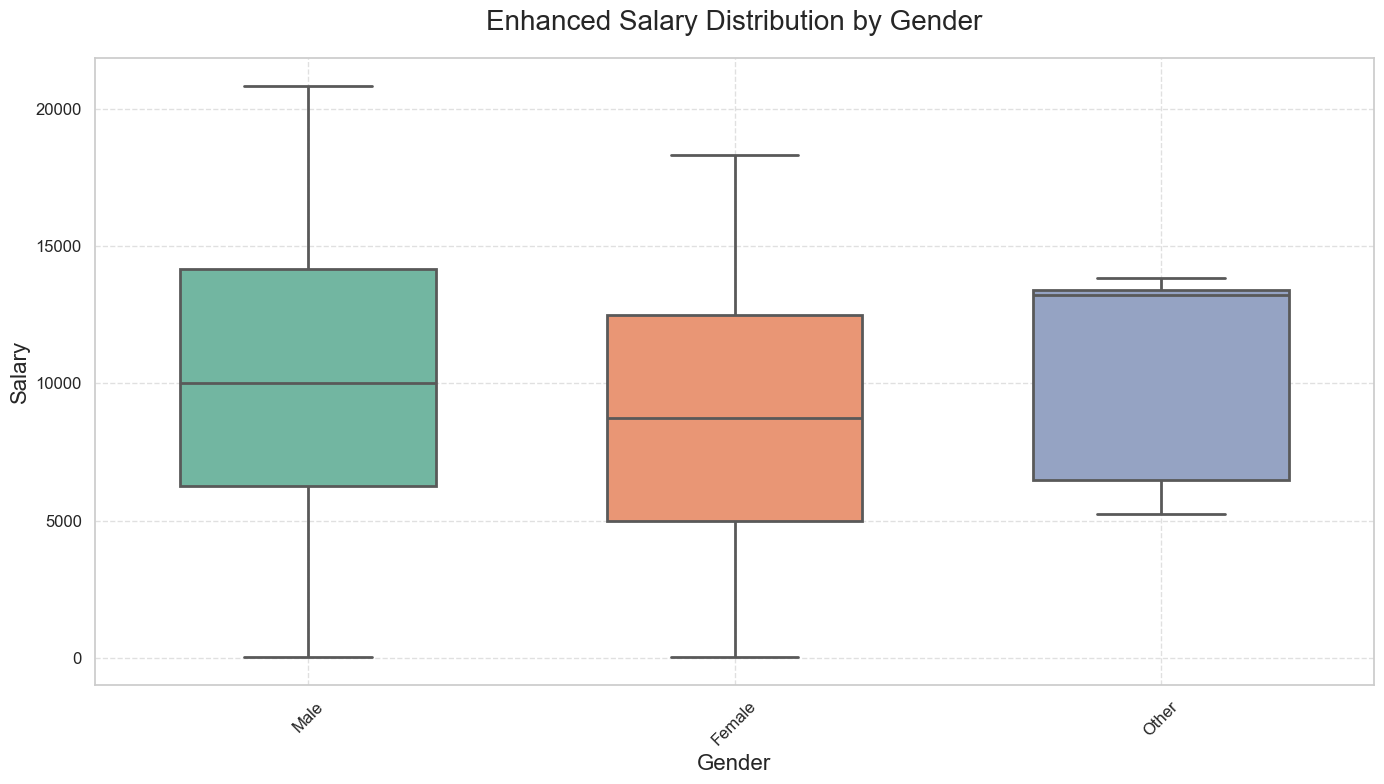

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_16723/923353576.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


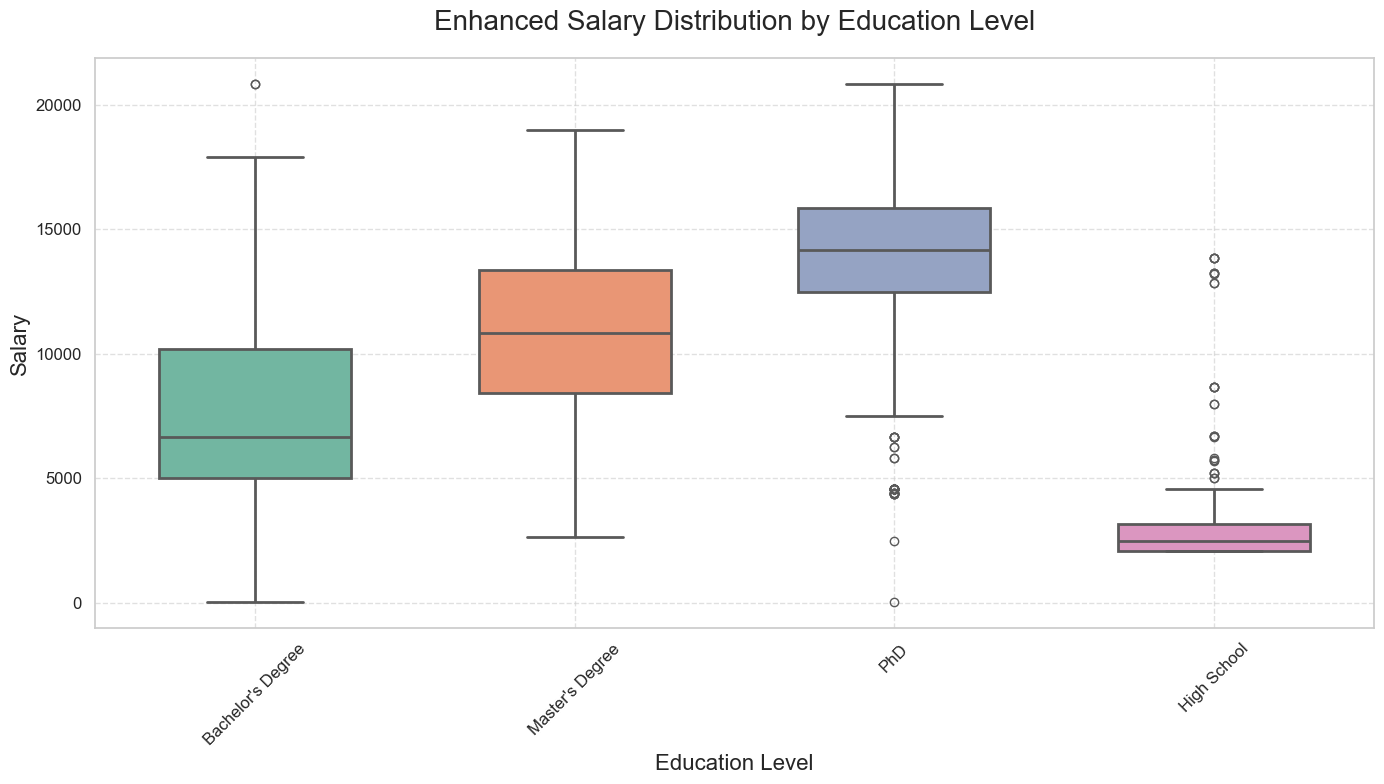

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_16723/923353576.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


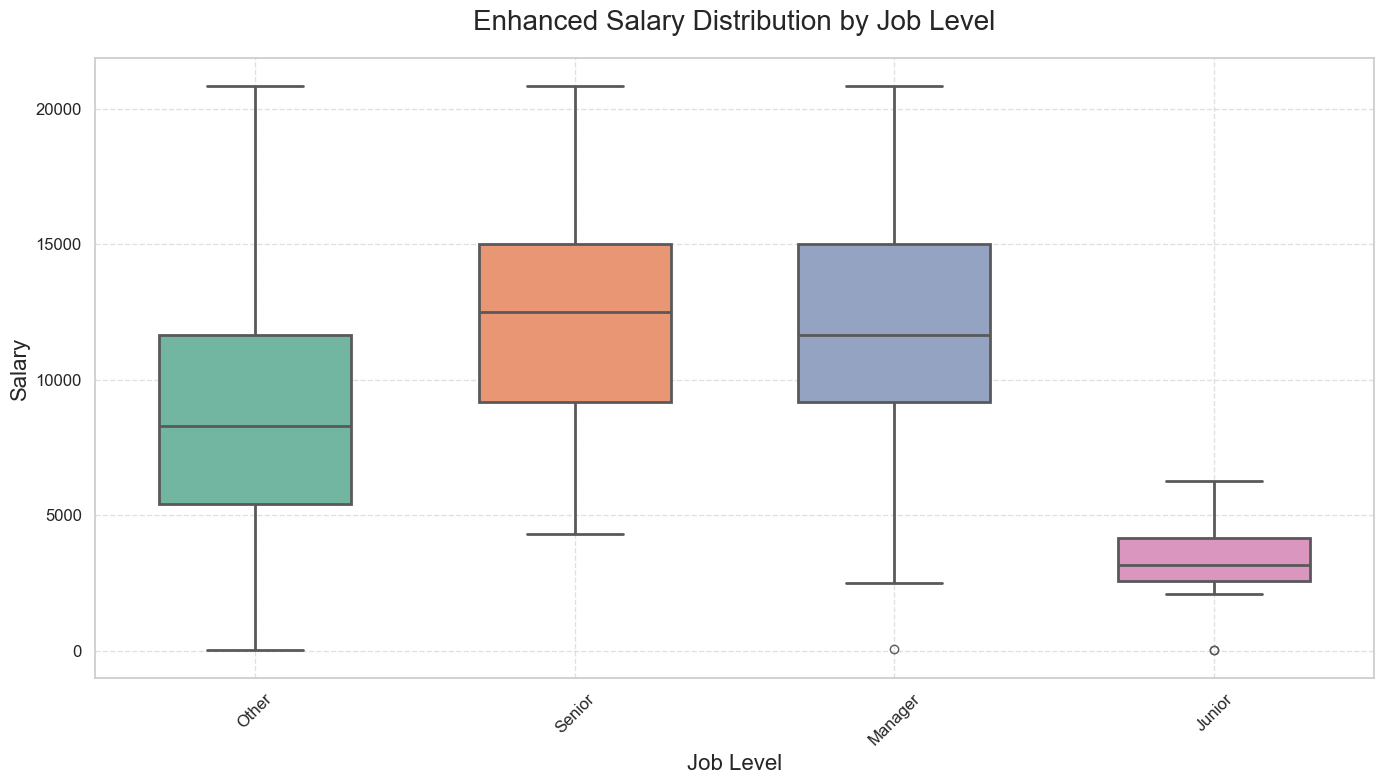

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_16723/923353576.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


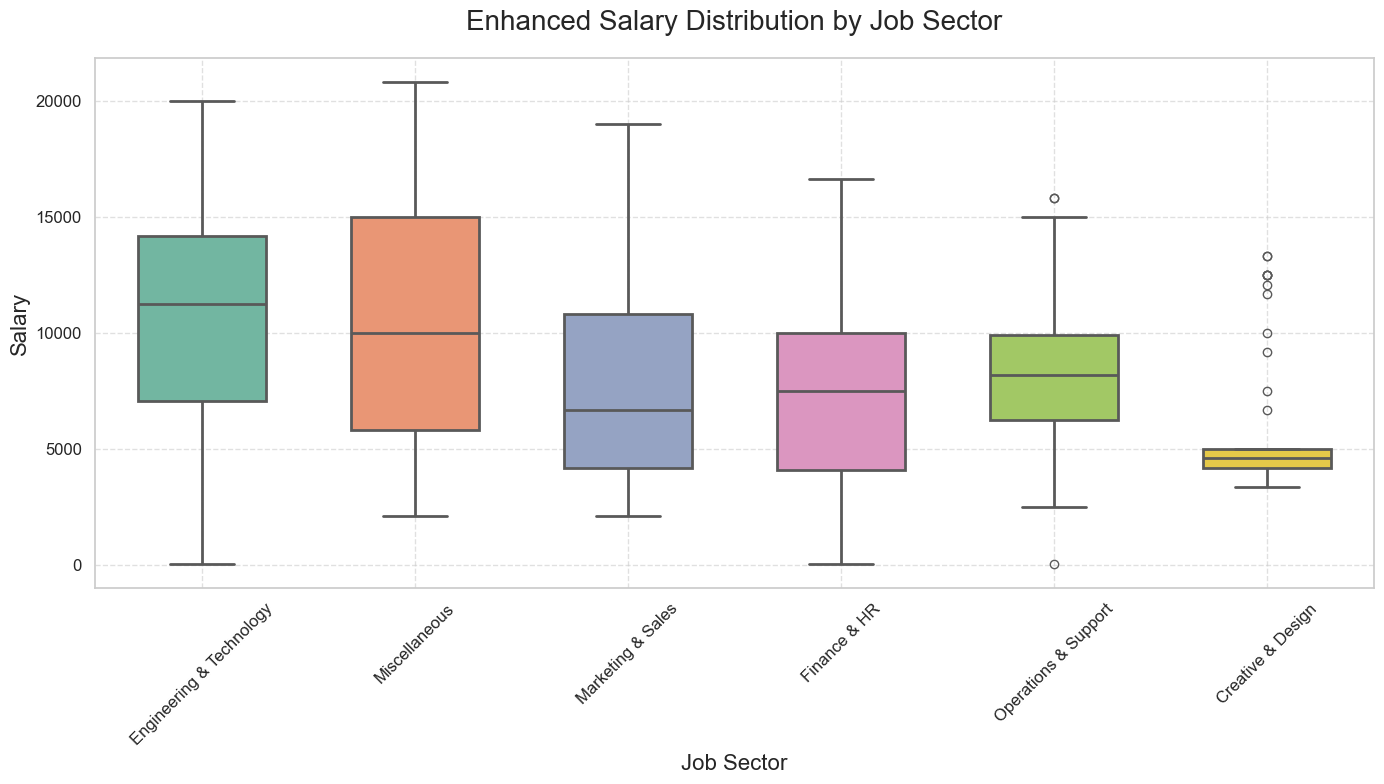

In [92]:
for category in new_df.select_dtypes('object'):
    plot_categorical_boxplot(new_df, category_col=category, numeric_col='Salary')

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


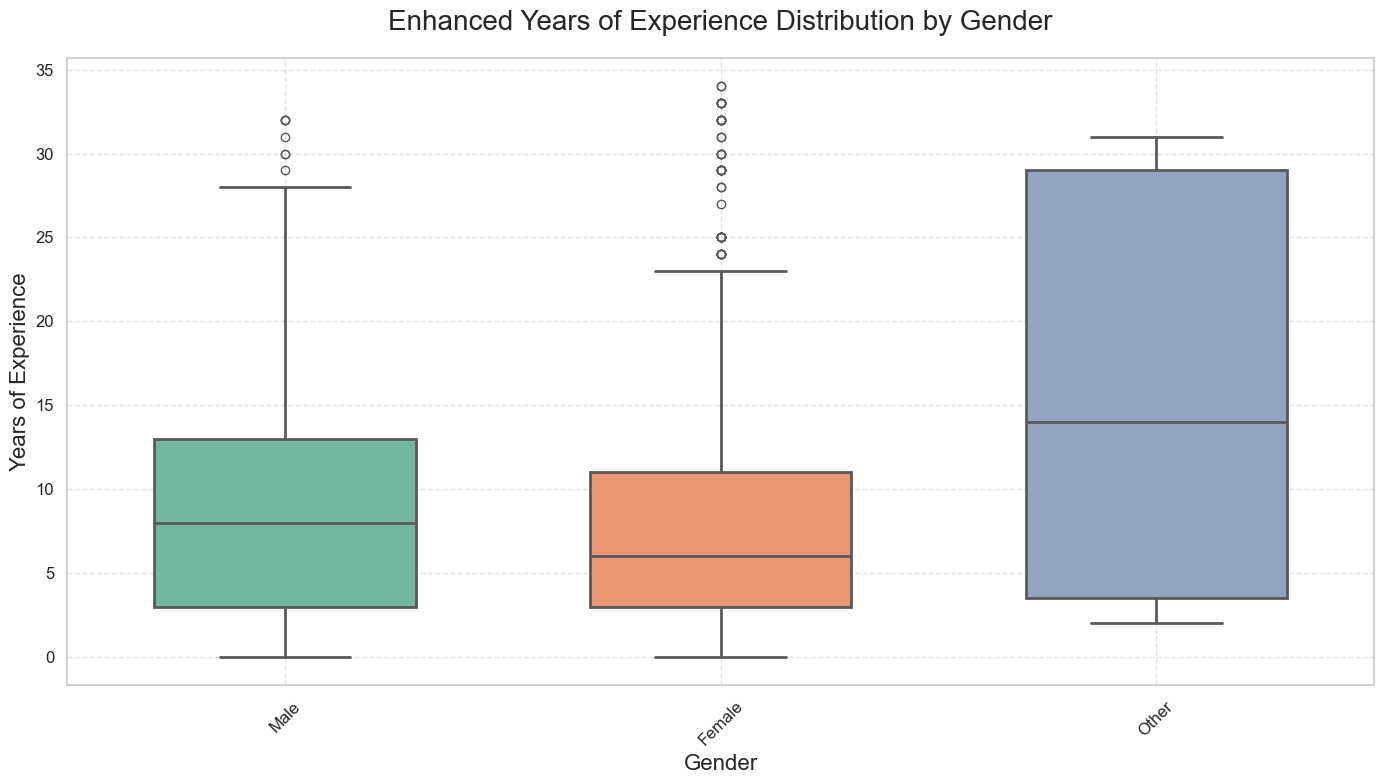

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


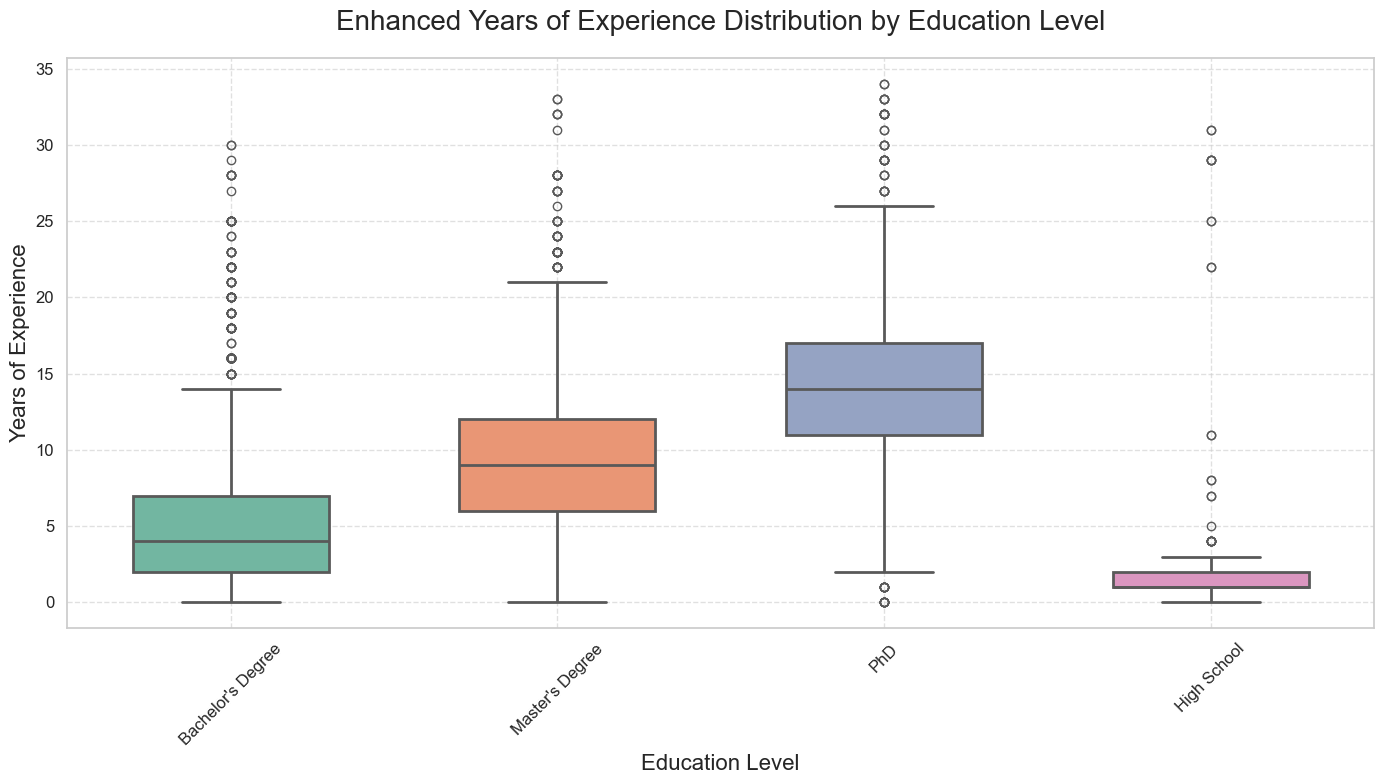

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


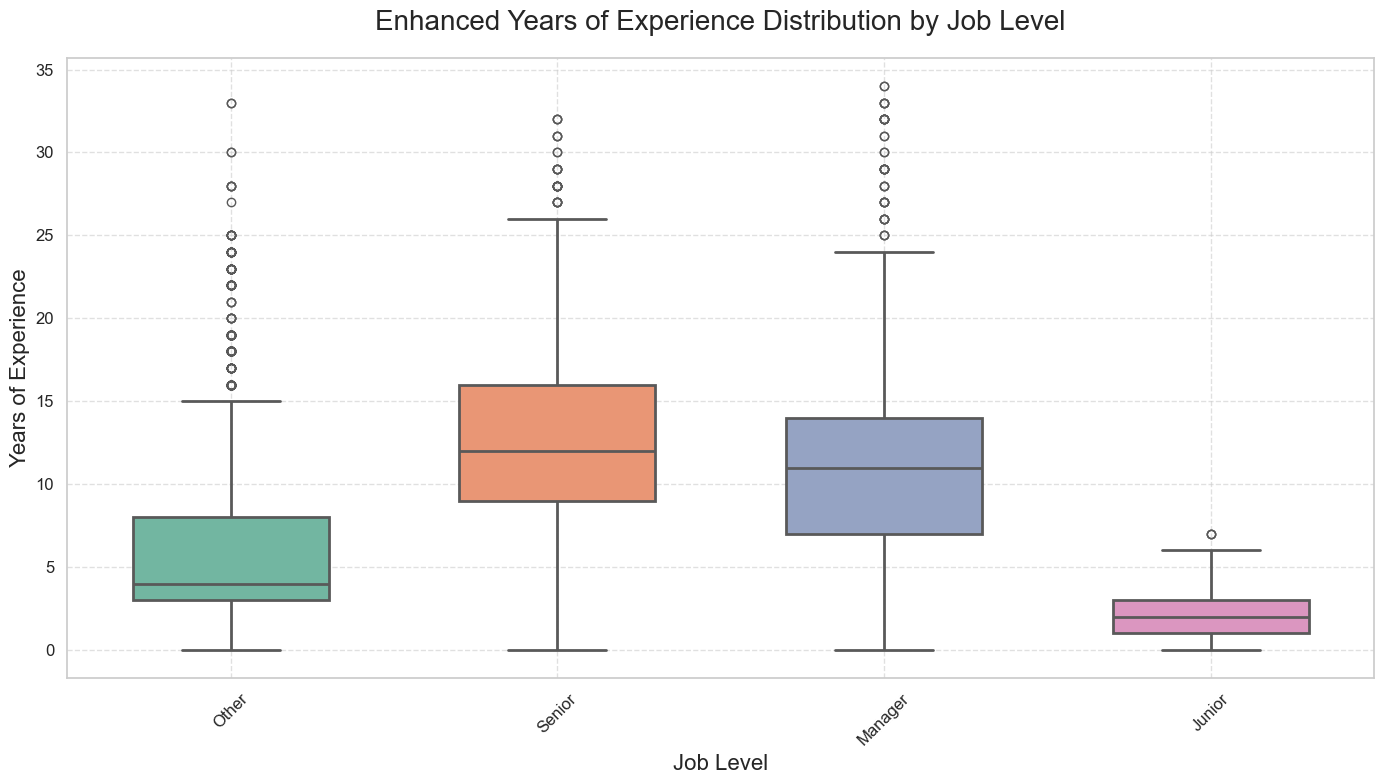

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/3686453733.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


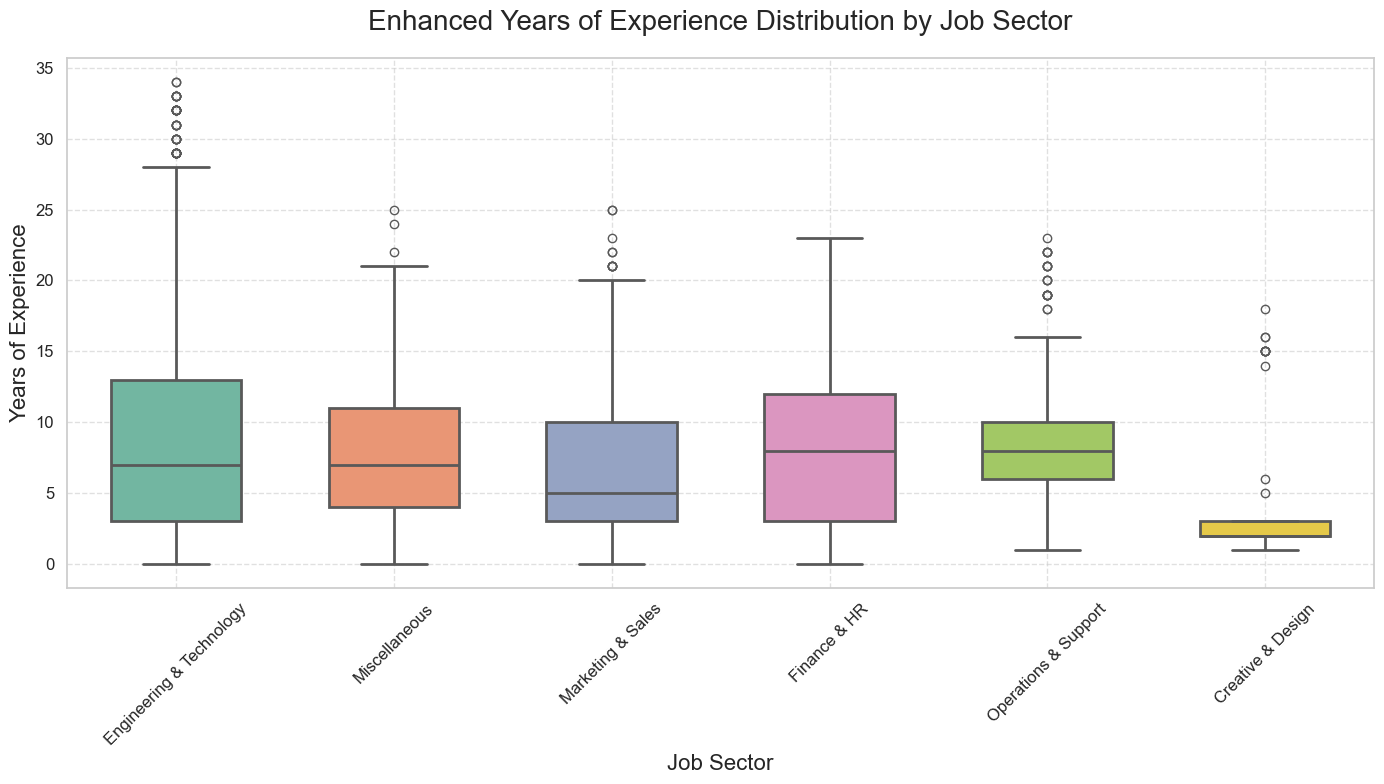

In [178]:
for category in new_df.select_dtypes('object'):
    plot_categorical_boxplot(new_df, category_col=category, numeric_col='Years of Experience')

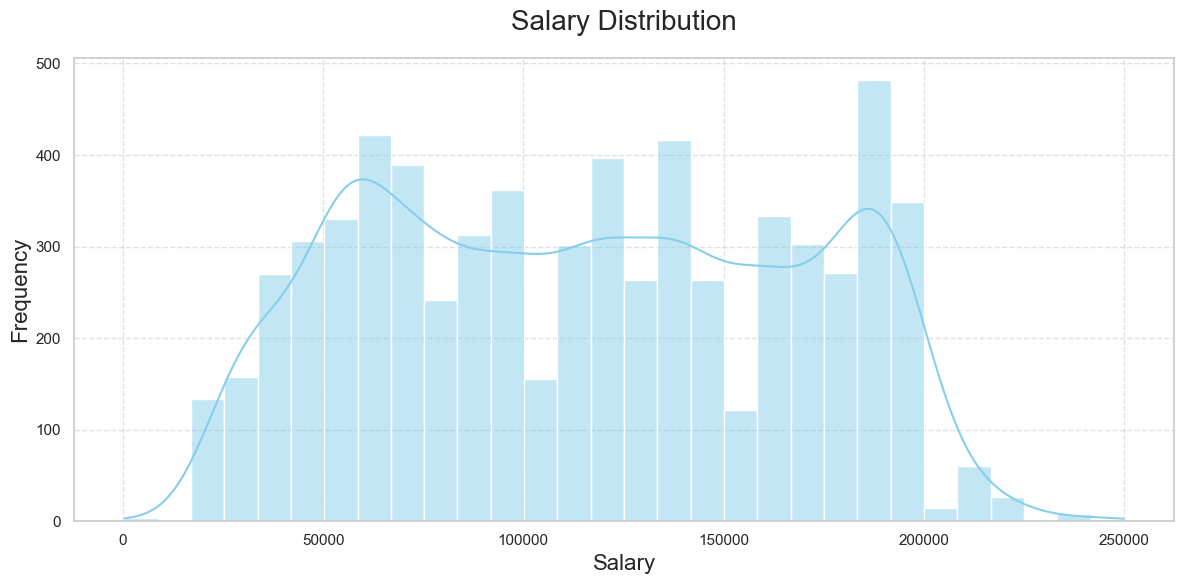

In [179]:
plot_histogram(new_df, column='Salary', title='Salary Distribution')

The data distrbution is differ from the old dataset, the most values between 50000, 250000

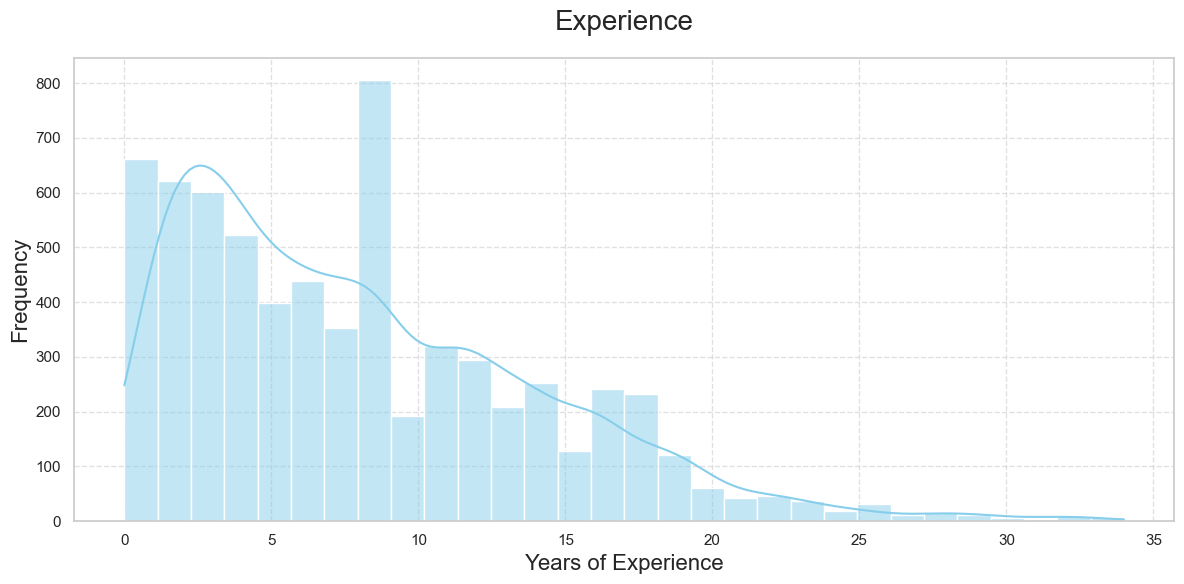

In [181]:
plot_histogram(new_df, column='Years of Experience', title='Experience')

The data distrbution is differ from the old dataset, the most values between 0, 35

In [271]:
for col in new_df.select_dtypes("object"):
  print(f"{col}: {new_df[col].unique()}")
  print(new_df[col].value_counts())
  print("\n \n \n")

Gender: ['Male' 'Female' nan 'Other']
Gender
Male      3674
Female    3014
Other       14
Name: count, dtype: int64

 
 

Education Level: ["Bachelor's Degree" "Master's Degree" 'PhD' nan 'High School']
Education Level
Bachelor's Degree    3023
Master's Degree      1861
PhD                  1369
High School           448
Name: count, dtype: int64

 
 

Job Level: ['Other' 'Senior' 'Manager' 'Junior']
Job Level
Other      3190
Manager    1972
Senior      969
Junior      573
Name: count, dtype: int64

 
 

Job Sector: ['Engineering & Technology' 'Miscellaneous' 'Marketing & Sales'
 'Finance & HR' 'Operations & Support' 'Creative & Design']
Job Sector
Engineering & Technology    3835
Marketing & Sales           1406
Miscellaneous                723
Finance & HR                 429
Operations & Support         200
Creative & Design            111
Name: count, dtype: int64

 
 



In [93]:
new_df['Salary'].isna().sum()

5

In [94]:
new_df = new_df[new_df['Salary'].isna()==False]

In [95]:
new_df['Salary'].isna().sum()

0

In [96]:
X = new_df.drop(columns = ['Salary'])
y = new_df['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [97]:
new_df.isna().sum()

Age                    0
Gender                 0
Education Level        1
Years of Experience    0
Salary                 0
Job Level              0
Job Sector             0
dtype: int64

In [315]:
new_df['Gender'] = new_df['Gender'].fillna("Other")
new_df['Education Level'] = new_df['Education Level'].fillna("Other") 

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/622950147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Gender'] = new_df['Gender'].fillna("Other")
/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_2777/622950147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Education Level'] = new_df['Education Level'].fillna("Other")


In [98]:
num_cols = X_train.select_dtypes("number").columns
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
num_pipe = make_pipeline(impute_median, scaler)
num_tuple = ('numeric', num_pipe, num_cols)

In [99]:
ord_cols = ["Education Level", "Job Level"]
Education_Level = ["Other","High School", "Bachelor's Degree", "Master's Degree", "PhD"]
Job_Level = ["Other","Junior", "Senior", "Manager"]

ordinal_category_orders = [Education_Level, Job_Level]

impute_na_ord = SimpleImputer(strategy='constant', fill_value='Other')

ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
scaler_ord = StandardScaler()
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_tuple = ('ordinal', ord_pipe, ord_cols)

In [100]:
ohe_cols = ['Gender','Job Sector']
impute_na_oh = SimpleImputer(strategy='constant', fill_value='Other')
ohe_encoder = OneHotEncoder(sparse_output=False)
ohe_pipe = make_pipeline(impute_na_oh, ohe_encoder)
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

In [101]:
col_transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple], verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Age', 'Years of Experience'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Other',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Other...
                                                                              "Master's "
                                                                              'Degree',
                                                                              'PhD'],
                                                                             ['Other',
                                                                              'Junior',
                                                                              'Senior',
                                                                              'Manager']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Education Level', 'Job Level']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Other',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['Gender', 'Job Sector'])],
                  verbose_feature_names_out=False)

In [102]:
rf = RandomForestRegressor(random_state=42)
rf_pipe = make_pipeline(col_transformer, rf)
rf_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Years of Experience'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('ordinalencode...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Education Level',
                                                   'Job Level']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Gender', 'Job Sector'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [103]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Years of Experience'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('ordinalencode...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Education Level',
                                                   'Job Level']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Gender', 'Job Sector'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [104]:
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 310.230
- MSE = 511,260.350
- RMSE = 715.025
- R^2 = 0.973

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 458.173
- MSE = 1,030,904.107
- RMSE = 1,015.334
- R^2 = 0.947


In [105]:
import joblib

# Save the trained model to a file
joblib.dump(rf_pipe, 'rf_pipe_model.pkl')


['rf_pipe_model.pkl']

## Acceptable accuracy in comprison with old data so we need to extrct these featres from the origonal data and use it insytead but theres overfit so we will try some else models

In [323]:
X_train_processed = col_transformer.fit_transform(X_train)
X_test_processed = col_transformer.transform(X_test)

X_train_processed = X_train_processed.values if hasattr(X_train_processed, 'values') else X_train_processed
y_train = y_train.values if hasattr(y_train, 'values') else y_train

if len(X_train_processed.shape) != 2:
    X_train_processed = X_train_processed.reshape(X_train_processed.shape[0], -1)

input_dim = X_train_processed.shape[1]

def create_enhanced_regression_model(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,), kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),  

        # Hidden layer 1
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),

        # Hidden layer 2
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),

        # Output layer
        layers.Dense(1)  
    ])

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='mse', 
        metrics=['mae']  
    )
    
    model.summary()
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

enhanced_model = create_enhanced_regression_model(input_dim)

history = enhanced_model.fit(
    X_train_processed, y_train,
    validation_split=0.2,  
    epochs=100,  
    batch_size=32,  
    callbacks=[early_stop],  
    verbose=1
)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 128)               1792      
                                                                 
 dropout_40 (Dropout)        (None, 128)               0         
                                                                 
 dense_62 (Dense)            (None, 64)                8256      
                                                                 
 dropout_41 (Dropout)        (None, 64)                0         
                                                                 
 dense_63 (Dense)            (None, 32)                2080      
                                                                 
 dropout_42 (Dropout)        (None, 32)                0         
                                                                 
 dense_64 (Dense)            (None, 1)               

In [324]:
evaluate_regression(enhanced_model, X_train_processed, y_train, X_test_processed, y_test)

157/157 [==============================] - 0s 710us/step
------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 1,395.216
- MSE = 3,392,678.003
- RMSE = 1,841.922
- R^2 = 0.824

53/53 [==============================] - 0s 739us/step
------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 1,380.650
- MSE = 3,382,109.136
- RMSE = 1,839.051
- R^2 = 0.827


In [325]:
new_df.describe()

Age  Years of Experience        Salary
count  6699.000000          6699.000000   6699.000000
mean     33.622033             8.095014   9610.580398
std       7.615646             6.059853   4398.848659
min      21.000000             0.000000     29.166667
25%      28.000000             3.000000   5833.333333
50%      32.000000             7.000000   9583.333333
75%      38.000000            12.000000  13333.333333
max      62.000000            34.000000  20833.333333

## Better accuracy with less overfit in comprison with the mean

In [15]:
new_df

Age  Gender    Education Level  Years of Experience        Salary  \
0     32.0    Male  Bachelor's Degree                  5.0   7500.000000   
1     28.0  Female    Master's Degree                  3.0   5416.666667   
2     45.0    Male                PhD                 15.0  12500.000000   
3     36.0  Female  Bachelor's Degree                  7.0   5000.000000   
4     52.0    Male    Master's Degree                 20.0  16666.666667   
...    ...     ...                ...                  ...           ...   
6699  49.0  Female                PhD                 20.0  16666.666667   
6700  32.0    Male        High School                  3.0   4166.666667   
6701  30.0  Female  Bachelor's Degree                  4.0   4583.333333   
6702  46.0    Male    Master's Degree                 14.0  11666.666667   
6703  26.0  Female        High School                  1.0   2916.666667   

     Job Level                Job Sector  
0        Other  Engineering & Technology  
1        Other  Engineering & Technology  
2       Senior             Miscellaneous  
3        Other         Marketing & Sales  
4      Manager             Miscellaneous  
...        ...                       ...  
6699   Manager         Marketing & Sales  
6700     Other         Marketing & Sales  
6701   Manager             Miscellaneous  
6702   Manager         Marketing & Sales  
6703     Other         Marketing & Sales  

[6704 rows x 7 columns]

In [16]:
df

Experience   Job Type Location Education Level                  Major  \
0           1.0  Temporary    Qatar         Unknown  IT & Computer Science   
1           2.0  Full-time  Unknown        Bachelor   Healthcare & Nursing   
2           3.0  Full-time  Unknown        Bachelor      Sales & Marketing   
3           1.0  Full-time  Unknown         Unknown        Food & Beverage   
4           2.0  Full-time  Unknown         Unknown  IT & Computer Science   
..          ...        ...      ...             ...                    ...   
995         2.0  Full-time      UAE         Unknown               Business   
996         4.0  Full-time  Unknown        Bachelor               Business   
997         0.0  Full-time      UAE         Unknown      Sales & Marketing   
998         0.0  Full-time      UAE         Unknown        Food & Beverage   
999         3.0  Full-time      UAE     High School  IT & Computer Science   

         Level         Industry  Salary_in_USD  
0    Assistant            Other    1236.263736  
1      Unknown       Healthcare    3746.543040  
2          Mid  Food & Beverage    1510.989011  
3       Junior      Hospitality     686.813187  
4      Unknown            Other     947.802198  
..         ...              ...            ...  
995  Assistant            Other     817.438692  
996    Unknown            Other    1975.476839  
997    Unknown           Retail     817.438692  
998     Junior      Hospitality     817.438692  
999  Assistant  Food & Beverage     544.959128  

[1000 rows x 8 columns]

#### I will try to create new dataset by keeping the common columns like: Experience, Education Level, Industry and Salary, Job level , I will drop Age, Gender, Major, and Job type

In [20]:
df_dropped_columns = df.drop(columns=['Job Type', 'Location', 'Major'])
df_dropped_columns

Experience Education Level      Level         Industry  Salary_in_USD
0           1.0         Unknown  Assistant            Other    1236.263736
1           2.0        Bachelor    Unknown       Healthcare    3746.543040
2           3.0        Bachelor        Mid  Food & Beverage    1510.989011
3           1.0         Unknown     Junior      Hospitality     686.813187
4           2.0         Unknown    Unknown            Other     947.802198
..          ...             ...        ...              ...            ...
995         2.0         Unknown  Assistant            Other     817.438692
996         4.0        Bachelor    Unknown            Other    1975.476839
997         0.0         Unknown    Unknown           Retail     817.438692
998         0.0         Unknown     Junior      Hospitality     817.438692
999         3.0     High School  Assistant  Food & Beverage     544.959128

[1000 rows x 5 columns]

In [22]:
df_dropped_columns = df_dropped_columns.rename(columns={
    'Salary_in_USD':'Salary'
})
df_dropped_columns

Experience Education Level      Level         Industry       Salary
0           1.0         Unknown  Assistant            Other  1236.263736
1           2.0        Bachelor    Unknown       Healthcare  3746.543040
2           3.0        Bachelor        Mid  Food & Beverage  1510.989011
3           1.0         Unknown     Junior      Hospitality   686.813187
4           2.0         Unknown    Unknown            Other   947.802198
..          ...             ...        ...              ...          ...
995         2.0         Unknown  Assistant            Other   817.438692
996         4.0        Bachelor    Unknown            Other  1975.476839
997         0.0         Unknown    Unknown           Retail   817.438692
998         0.0         Unknown     Junior      Hospitality   817.438692
999         3.0     High School  Assistant  Food & Beverage   544.959128

[1000 rows x 5 columns]

In [21]:
newdf_dropped_columns = new_df.drop(columns=['Age', 'Gender'])
newdf_dropped_columns

Education Level  Years of Experience        Salary Job Level  \
0     Bachelor's Degree                  5.0   7500.000000     Other   
1       Master's Degree                  3.0   5416.666667     Other   
2                   PhD                 15.0  12500.000000    Senior   
3     Bachelor's Degree                  7.0   5000.000000     Other   
4       Master's Degree                 20.0  16666.666667   Manager   
...                 ...                  ...           ...       ...   
6699                PhD                 20.0  16666.666667   Manager   
6700        High School                  3.0   4166.666667     Other   
6701  Bachelor's Degree                  4.0   4583.333333   Manager   
6702    Master's Degree                 14.0  11666.666667   Manager   
6703        High School                  1.0   2916.666667     Other   

                    Job Sector  
0     Engineering & Technology  
1     Engineering & Technology  
2                Miscellaneous  
3            Marketing & Sales  
4                Miscellaneous  
...                        ...  
6699         Marketing & Sales  
6700         Marketing & Sales  
6701             Miscellaneous  
6702         Marketing & Sales  
6703         Marketing & Sales  

[6704 rows x 5 columns]

In [23]:
newdf_dropped_columns = newdf_dropped_columns.rename(columns={
    'Education Level':'Education Level', 
    'Job Level':'Level', 
    'Job Sector':'Industry', 
    'Years of Experience':'Experience'
})
newdf_dropped_columns

Education Level  Experience        Salary    Level  \
0     Bachelor's Degree         5.0   7500.000000    Other   
1       Master's Degree         3.0   5416.666667    Other   
2                   PhD        15.0  12500.000000   Senior   
3     Bachelor's Degree         7.0   5000.000000    Other   
4       Master's Degree        20.0  16666.666667  Manager   
...                 ...         ...           ...      ...   
6699                PhD        20.0  16666.666667  Manager   
6700        High School         3.0   4166.666667    Other   
6701  Bachelor's Degree         4.0   4583.333333  Manager   
6702    Master's Degree        14.0  11666.666667  Manager   
6703        High School         1.0   2916.666667    Other   

                      Industry  
0     Engineering & Technology  
1     Engineering & Technology  
2                Miscellaneous  
3            Marketing & Sales  
4                Miscellaneous  
...                        ...  
6699         Marketing & Sales  
6700         Marketing & Sales  
6701             Miscellaneous  
6702         Marketing & Sales  
6703         Marketing & Sales  

[6704 rows x 5 columns]

In [37]:
concatenated_df = pd.concat([newdf_dropped_columns, df_dropped_columns], ignore_index=True)
concatenated_df

Education Level  Experience        Salary      Level  \
0     Bachelor's Degree         5.0   7500.000000      Other   
1       Master's Degree         3.0   5416.666667      Other   
2                   PhD        15.0  12500.000000     Senior   
3     Bachelor's Degree         7.0   5000.000000      Other   
4       Master's Degree        20.0  16666.666667    Manager   
...                 ...         ...           ...        ...   
7699            Unknown         2.0    817.438692  Assistant   
7700           Bachelor         4.0   1975.476839    Unknown   
7701            Unknown         0.0    817.438692    Unknown   
7702            Unknown         0.0    817.438692     Junior   
7703        High School         3.0    544.959128  Assistant   

                      Industry  
0     Engineering & Technology  
1     Engineering & Technology  
2                Miscellaneous  
3            Marketing & Sales  
4                Miscellaneous  
...                        ...  
7699                     Other  
7700                     Other  
7701                    Retail  
7702               Hospitality  
7703           Food & Beverage  

[7704 rows x 5 columns]

In [27]:
concatenated_df.describe()

Experience         Salary
count  7701.000000    7699.000000
mean      7.279639    8659.778207
std       6.088898    8469.228442
min       0.000000      14.850136
25%       2.000000    4583.333333
50%       6.000000    8333.333333
75%      11.000000   12916.666667
max      34.000000  587500.000000

In [28]:
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7704 entries, 0 to 7703
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Education Level  7701 non-null   object 
 1   Experience       7701 non-null   float64
 2   Salary           7699 non-null   float64
 3   Level            7704 non-null   object 
 4   Industry         7704 non-null   object 
dtypes: float64(2), object(3)
memory usage: 301.1+ KB


In [29]:
for col in concatenated_df.select_dtypes("object"):
  print(f"{col}: {concatenated_df[col].unique()}")
  print(concatenated_df[col].value_counts())
  print("\n \n \n")

Education Level: ["Bachelor's Degree" "Master's Degree" 'PhD' nan 'High School' 'Unknown'
 'Bachelor' 'College' 'Diploma' 'Bachelor/Master' 'Master' 'Doctorate']
Education Level
Bachelor's Degree    3023
Master's Degree      1861
PhD                  1369
Unknown               653
High School           490
Bachelor              240
Diploma                45
College                 7
Bachelor/Master         5
Master                  5
Doctorate               3
Name: count, dtype: int64

 
 

Level: ['Other' 'Senior' 'Manager' 'Junior' 'Assistant' 'Unknown' 'Mid'
 'Executive' 'Lead' 'Intern' 'Trainer' 'Academic' 'Volunteer' 'Support']
Level
Other        3190
Manager      2080
Senior       1073
Junior        658
Unknown       422
Executive     111
Assistant      89
Lead           57
Mid            14
Intern          4
Trainer         3
Academic        1
Volunteer       1
Support         1
Name: count, dtype: int64

 
 

Industry: ['Engineering & Technology' 'Miscellaneous' 'Marketing & Sa

In [38]:
education_mapping = {
    "Bachelor's Degree": "Bachelor",
    "Bachelor": "Bachelor",
    "Master's Degree": "Master",
    "Master": "Master",
    "PhD": "Doctorate",
    "Doctorate": "Doctorate",
    "High School": "High School",
    "College": "Diploma",
    "Diploma": "Diploma",
    "Bachelor/Master": "Bachelor/Master",
    None: "Other",
    "Unknown": "Other"
}

concatenated_df['Education Level'] = concatenated_df['Education Level'].map(education_mapping).fillna('Other')

In [39]:
level_mapping = {
    "Other": "Other",
    "Senior": "Senior",
    "Manager": "Manager",
    "Junior": "Junior",
    "Assistant": "Junior",
    "Unknown": "Other",
    "Mid": "Mid",
    "Executive": "Senior",
    "Lead": "Senior",
    "Intern": "Junior",
    "Trainer": "Other",
    "Academic": "Other",
    "Volunteer": "Other",
    "Support": "Other"
}

concatenated_df['Level'] = concatenated_df['Level'].map(level_mapping).fillna('Other')

In [40]:
industry_mapping = {
    "Engineering & Technology": "Technology",
    "Miscellaneous": "Other",
    "Marketing & Sales": "Marketing/Sales",
    "Finance & HR": "Finance/HR",
    "Operations & Support": "Operations",
    "Creative & Design": "Creative",
    "Other": "Other",
    "Healthcare": "Healthcare",
    "Food & Beverage": "Food/Beverage",
    "Hospitality": "Hospitality",
    "Retail": "Retail",
    "Manufacturing": "Manufacturing",
    "Real Estate": "Real Estate",
    "Technology": "Technology",
    "Recreation": "Recreation",
    "Services": "Services",
    "Education": "Education",
    "Construction": "Construction",
    "Energy": "Energy",
    "Advertising": "Advertising",
    "Tourism": "Tourism",
    "Banking": "Banking",
    "Finance": "Finance/HR",
    "Pharmaceuticals": "Healthcare",
    "Entertainment": "Entertainment",
    "Cosmetics": "Other",
    "Human Resources": "Finance/HR",
    "Ecommerce": "Retail",
    "Food & Beverage/Beauty": "Food/Beverage",
    "Travel": "Tourism",
    "Logistics": "Logistics",
    "Security": "Other",
    "Law": "Other",
    "Management": "Management",
    "Agriculture": "Other",
    "Advertising/Marketing": "Marketing/Sales"
}

concatenated_df['Industry'] = concatenated_df['Industry'].map(industry_mapping).fillna('Other')

In [33]:
for col in concatenated_df.select_dtypes("object"):
  print(f"{col}: {concatenated_df[col].unique()}")
  print(concatenated_df[col].value_counts())
  print("\n \n \n")

Education Level: ['Bachelor' 'Master' 'Doctorate' 'Other' 'High School' 'Diploma'
 'Bachelor/Master']
Education Level
Bachelor           3263
Master             1866
Doctorate          1372
Other               656
High School         490
Diploma              52
Bachelor/Master       5
Name: count, dtype: int64

 
 

Level: ['Other' 'Senior' 'Manager' 'Junior' 'Mid']
Level
Other      3618
Manager    2080
Senior     1241
Junior      751
Mid          14
Name: count, dtype: int64

 
 

Industry: ['Technology' 'Other' 'Marketing/Sales' 'Finance/HR' 'Operations'
 'Creative' 'Healthcare' 'Food/Beverage' 'Hospitality' 'Retail'
 'Manufacturing' 'Real Estate' 'Recreation' 'Services' 'Education'
 'Construction' 'Energy' 'Advertising' 'Tourism' 'Banking' 'Entertainment'
 'Logistics' 'Management']
Industry
Technology         3914
Marketing/Sales    1407
Other              1041
Finance/HR          448
Operations          200
Retail              131
Creative            111
Healthcare           89
Rea

In [41]:
industry_reduction_mapping = {
    "Technology": "Technology & Engineering",
    "Marketing/Sales": "Sales & Marketing",
    "Advertising": "Sales & Marketing",
    "Finance/HR": "Finance & Business Services",
    "Banking": "Finance & Business Services",
    "Management": "Finance & Business Services",
    "Healthcare": "Healthcare & Pharmaceuticals",
    "Retail": "Retail & Consumer Goods",
    "Food/Beverage": "Retail & Consumer Goods",
    "Creative": "Creative & Entertainment",
    "Entertainment": "Creative & Entertainment",
    "Hospitality": "Hospitality & Tourism",
    "Tourism": "Hospitality & Tourism",
    "Manufacturing": "Industrial & Manufacturing",
    "Construction": "Industrial & Manufacturing",
    "Logistics": "Industrial & Manufacturing",
    "Real Estate": "Industrial & Manufacturing",
    "Energy": "Energy & Resources",
    "Education": "Education & Services",
    "Services": "Education & Services",
    "Other": "Miscellaneous",
    "Recreation": "Miscellaneous",
    "Operations": "Miscellaneous"
}
concatenated_df['Industry'] = concatenated_df['Industry'].map(industry_reduction_mapping)
industry_counts = concatenated_df['Industry'].value_counts()

0       Technology & Engineering
1       Technology & Engineering
2                  Miscellaneous
3              Sales & Marketing
4                  Miscellaneous
                  ...           
7699               Miscellaneous
7700               Miscellaneous
7701     Retail & Consumer Goods
7702       Hospitality & Tourism
7703     Retail & Consumer Goods
Name: Industry, Length: 7704, dtype: object

In [42]:
concatenated_df['Industry'].value_counts()

Industry
Technology & Engineering        3914
Sales & Marketing               1422
Miscellaneous                   1243
Finance & Business Services      454
Industrial & Manufacturing       201
Retail & Consumer Goods          159
Creative & Entertainment         113
Healthcare & Pharmaceuticals      89
Hospitality & Tourism             55
Education & Services              52
Energy & Resources                 2
Name: count, dtype: int64

In [43]:
concatenated_df

Education Level  Experience        Salary    Level  \
0           Bachelor         5.0   7500.000000    Other   
1             Master         3.0   5416.666667    Other   
2          Doctorate        15.0  12500.000000   Senior   
3           Bachelor         7.0   5000.000000    Other   
4             Master        20.0  16666.666667  Manager   
...              ...         ...           ...      ...   
7699           Other         2.0    817.438692   Junior   
7700        Bachelor         4.0   1975.476839    Other   
7701           Other         0.0    817.438692    Other   
7702           Other         0.0    817.438692   Junior   
7703     High School         3.0    544.959128   Junior   

                      Industry  
0     Technology & Engineering  
1     Technology & Engineering  
2                Miscellaneous  
3            Sales & Marketing  
4                Miscellaneous  
...                        ...  
7699             Miscellaneous  
7700             Miscellaneous  
7701   Retail & Consumer Goods  
7702     Hospitality & Tourism  
7703   Retail & Consumer Goods  

[7704 rows x 5 columns]

In [44]:
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7704 entries, 0 to 7703
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Education Level  7704 non-null   object 
 1   Experience       7701 non-null   float64
 2   Salary           7699 non-null   float64
 3   Level            7704 non-null   object 
 4   Industry         7704 non-null   object 
dtypes: float64(2), object(3)
memory usage: 301.1+ KB


In [45]:
concatenated_df['Salary'].isna().sum()

5

### I will drop the columns that dosent contains salary because we can't impute the target!

In [46]:
concatenated_df = concatenated_df[concatenated_df['Salary'].isna()==False]
concatenated_df['Salary'].isna().sum()

0

In [47]:
concatenated_df.isna().sum()

Education Level    0
Experience         0
Salary             0
Level              0
Industry           0
dtype: int64

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_16723/923353576.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


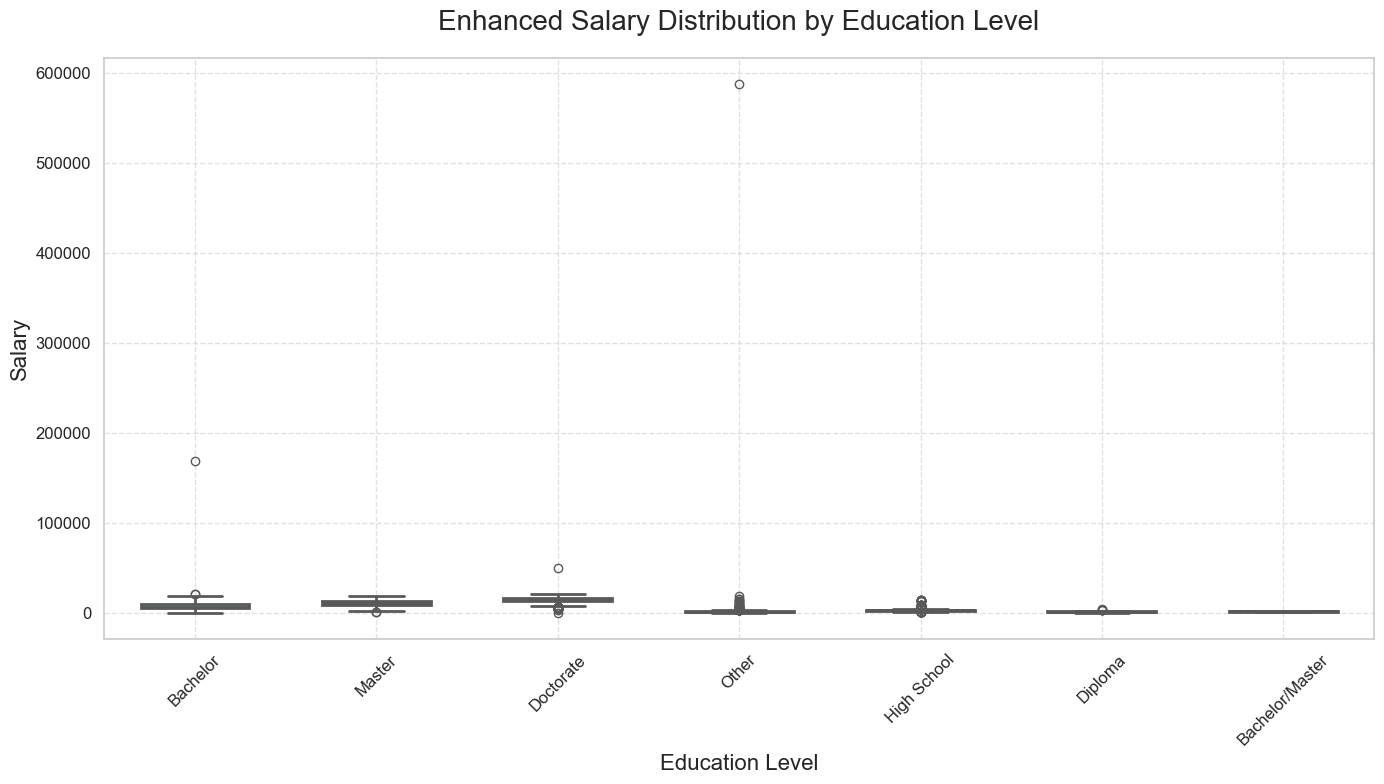

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_16723/923353576.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


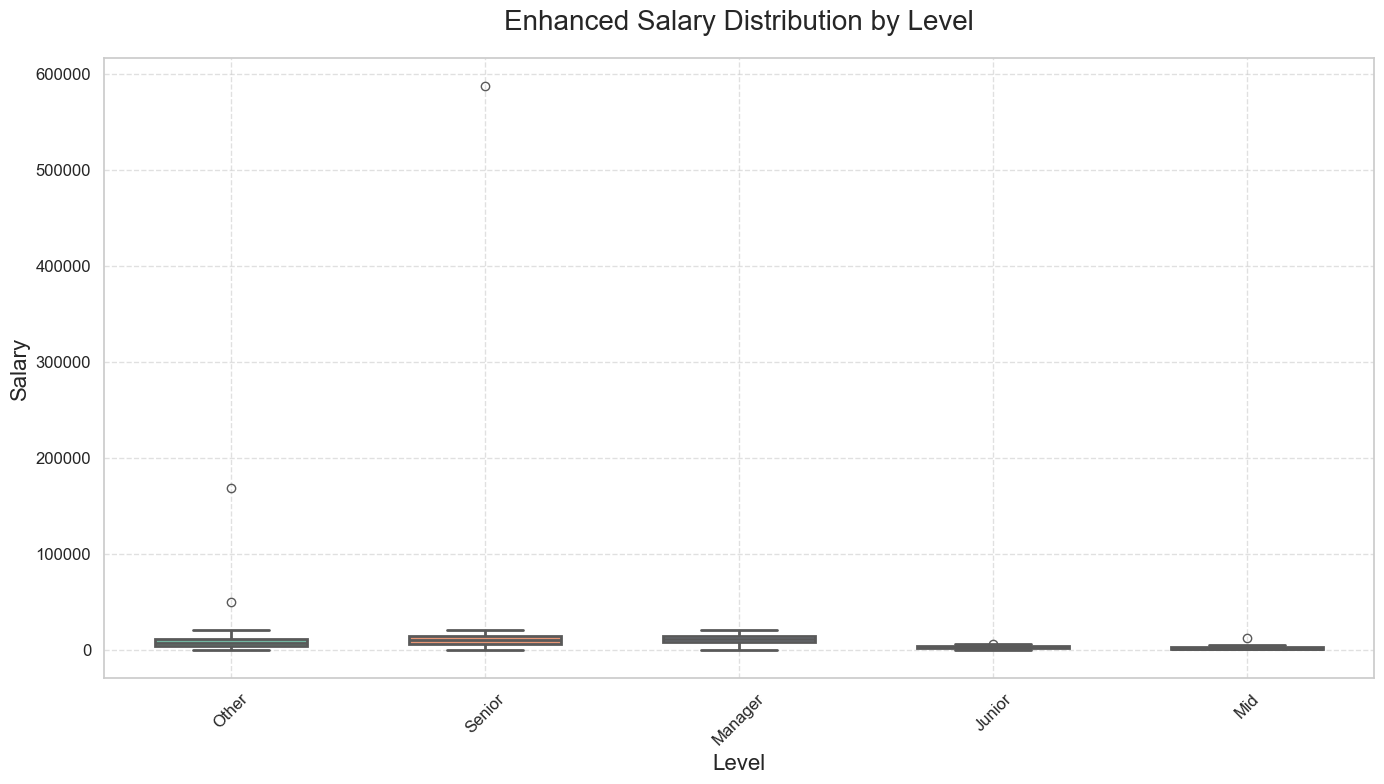

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_16723/923353576.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


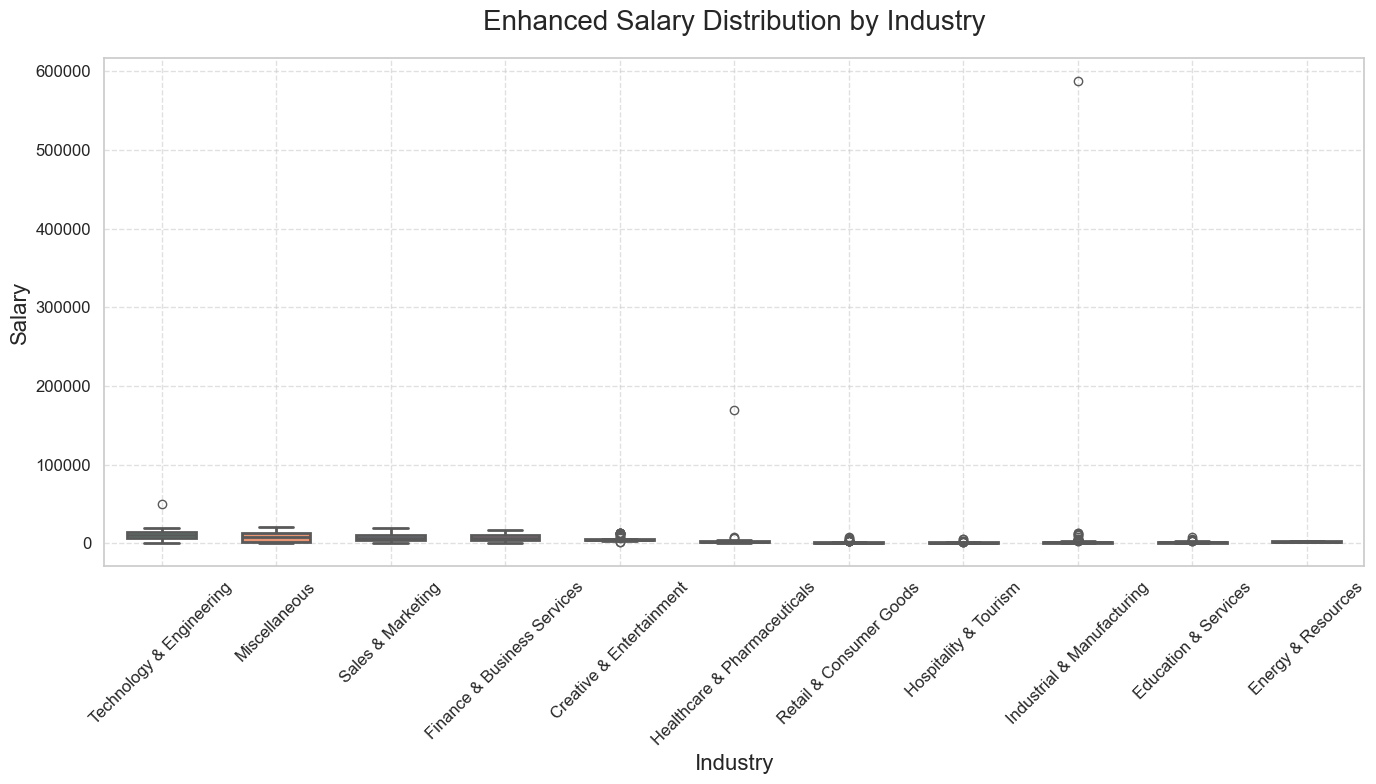

In [70]:
for category in concatenated_df.select_dtypes('object'):
    plot_categorical_boxplot(concatenated_df, category_col=category, numeric_col='Salary')

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_16723/923353576.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=x_col, palette='pastel')


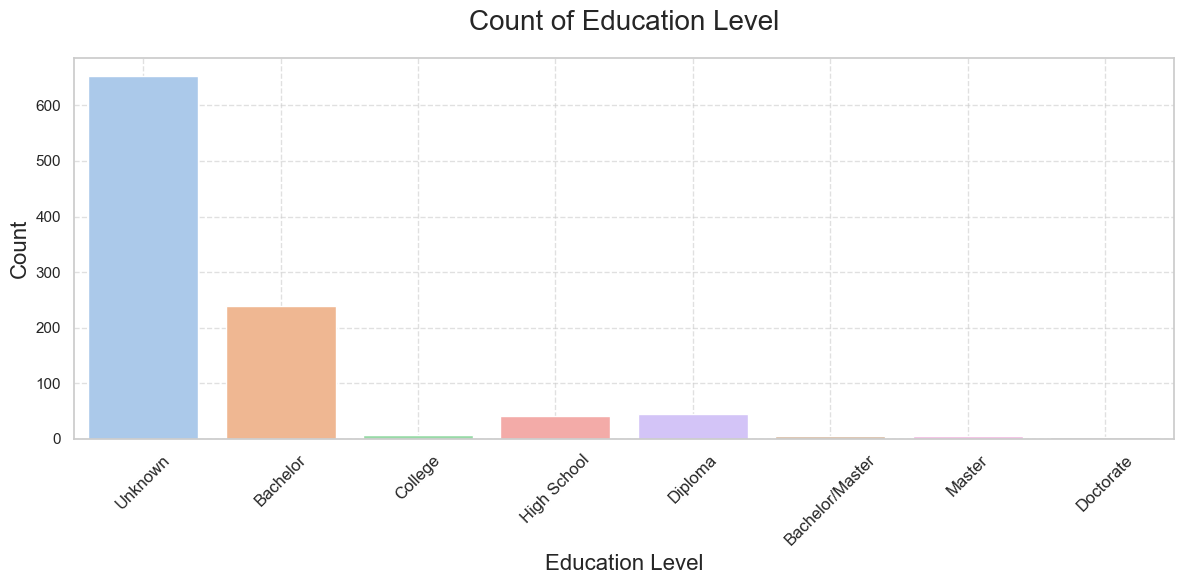

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_16723/923353576.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=x_col, palette='pastel')


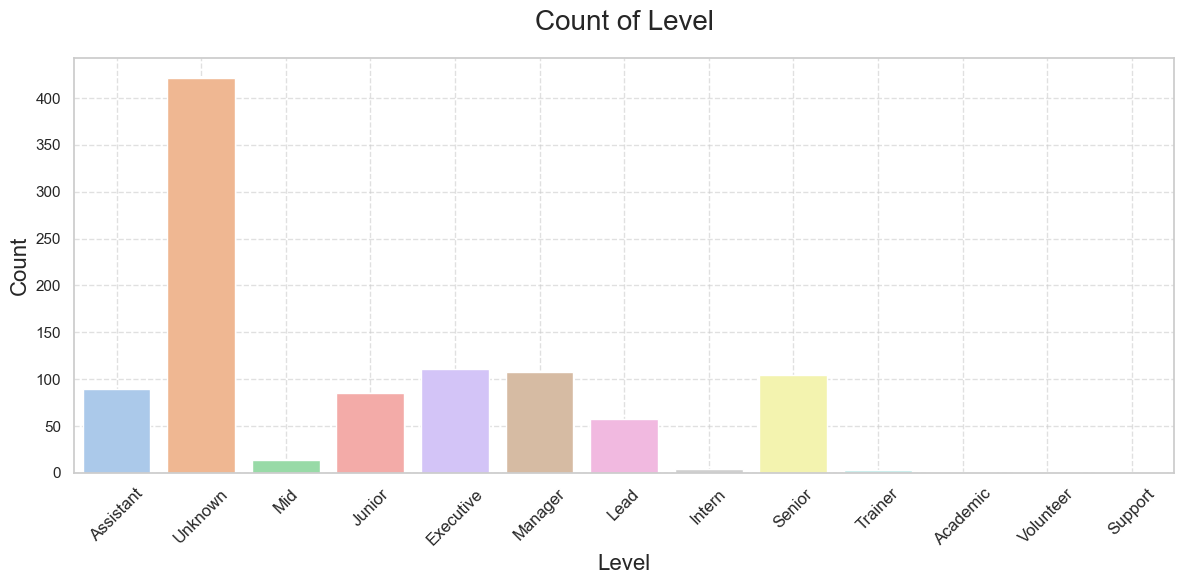

/var/folders/hz/trrpkmvx0ggf7ch6thxq7yc40000gn/T/ipykernel_16723/923353576.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=x_col, palette='pastel')


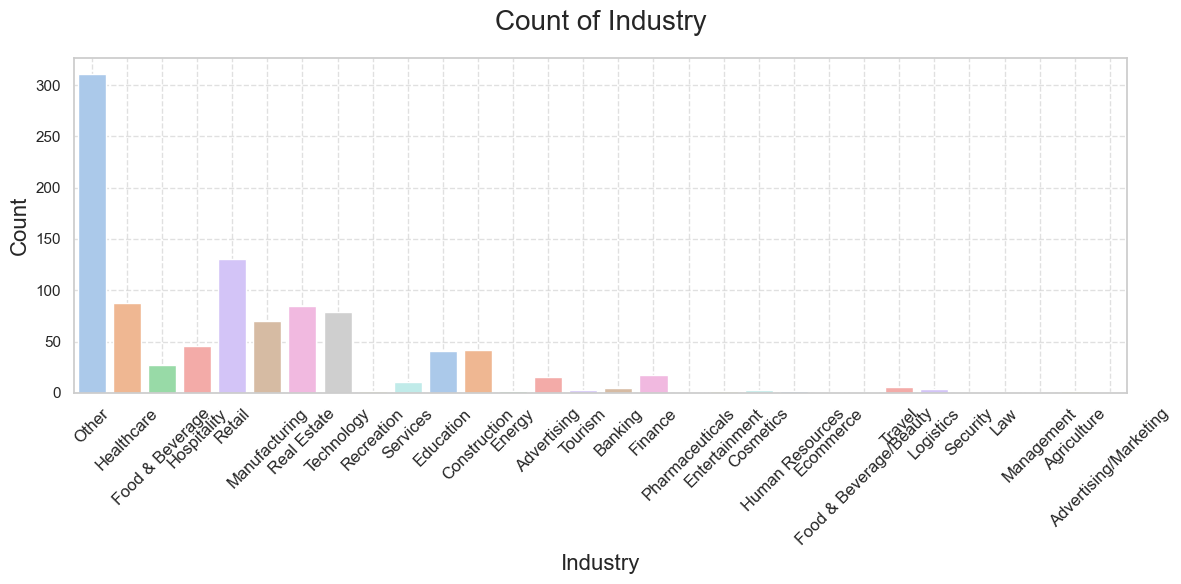

In [71]:
for category in concatenated_df.select_dtypes('object'):
    plot_bar(df, x_col=category, title=f'Count of {category}')

In [48]:
X = concatenated_df.drop(columns = ['Salary'])
y = concatenated_df['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [49]:
num_cols = X_train.select_dtypes("number").columns
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
num_pipe = make_pipeline(impute_median, scaler)
num_tuple = ('numeric', num_pipe, num_cols)

In [52]:
ord_cols = ["Education Level", "Level"]
Education_Level = ['Other', 'High School', 'Diploma', 'Bachelor', 'Bachelor/Master', 'Master', 'Doctorate']
Level = ['Other', 'Senior', 'Manager', 'Junior', 'Mid']

ordinal_category_orders = [Education_Level, Level]

impute_na_ord = SimpleImputer(strategy='constant', fill_value='Other')

ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
scaler_ord = StandardScaler()
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_tuple = ('ordinal', ord_pipe, ord_cols)

In [58]:
ohe_cols = ['Industry']
impute_na_oh = SimpleImputer(strategy='constant', fill_value='Other')
ohe_encoder = OneHotEncoder(sparse_output=False)
ohe_pipe = make_pipeline(impute_na_oh, ohe_encoder)
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

In [59]:
col_transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple], verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Experience'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Other',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Other',
                                                                              'High '
                                                                              'Scho...
                                                                              'Bachelor/Master',
                                                                              'Master',
                                                                              'Doctorate'],
                                                                             ['Other',
                                                                              'Senior',
                                                                              'Manager',
                                                                              'Junior',
                                                                              'Mid']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Education Level', 'Level']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Other',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['Industry'])],
                  verbose_feature_names_out=False)

In [60]:
rf = RandomForestRegressor(random_state=42)
rf_pipe = make_pipeline(col_transformer, rf)
rf_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Experience'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEnc...
                                                                                               'Junior',
                                                                                               'Mid']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Education Level', 'Level']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Industry'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [61]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Experience'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEnc...
                                                                                               'Junior',
                                                                                               'Mid']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Education Level', 'Level']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Industry'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [62]:
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 1,081.229
- MSE = 46,924,915.545
- RMSE = 6,850.176
- R^2 = 0.462

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 1,055.926
- MSE = 5,574,791.469
- RMSE = 2,361.100
- R^2 = 0.779


### Lets try Random Forest with hyberparameters tuning

In [68]:
params = {
 'bootstrap': [True, False],
 # 'ccp_alpha': [0.1,0.25,0.5,0.75],
 'max_depth': [None,10,15,20],
 'min_samples_leaf':[2,3,4],
 # 'min_samples_split': [2,3,4],
 'n_estimators': [10,100,150,200],
 # 'n_jobs': [2, 3, 4, 5],
 # 'oob_score': [True, False],
 # 'verbose': [0, 1, 2, 3],
 # 'warm_start': [True, False] 
}
gs = GridSearchCV(rf, param_grid=params, cv=5)
gs_pipe = make_pipeline(col_transformer, gs)
gs_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Experience'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEnc...
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Industry'])],
                                   verbose_feature_names_out=False)),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=RandomForestRegressor(random_state=42),
                              param_grid={'bootstrap': [True, False],
                                          'max_depth': [None, 10, 15, 20],
                                          'min_samples_leaf': [2, 3, 4],
                                          'n_estimators': [10, 100, 150,
                                                           200]}))])

In [69]:
evaluate_regression(gs_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 1,170.347
- MSE = 58,912,376.715
- RMSE = 7,675.440
- R^2 = 0.324

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 1,121.863
- MSE = 7,427,163.053
- RMSE = 2,725.282
- R^2 = 0.706


### Not good quality, lets try Deep learning

In [65]:
X_train_processed = col_transformer.fit_transform(X_train)
X_test_processed = col_transformer.transform(X_test)

X_train_processed = X_train_processed.values if hasattr(X_train_processed, 'values') else X_train_processed
y_train = y_train.values if hasattr(y_train, 'values') else y_train

if len(X_train_processed.shape) != 2:
    X_train_processed = X_train_processed.reshape(X_train_processed.shape[0], -1)

input_dim = X_train_processed.shape[1]

def create_enhanced_regression_model(input_dim):
    model = models.Sequential([
        layers.Dense(1024, activation='relu', input_shape=(input_dim,), kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),  

        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),

        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),

        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),

        layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),

        # Output layer
        layers.Dense(1)  
    ])

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='mse', 
        metrics=['mae']  
    )
    
    model.summary()
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

enhanced_model = create_enhanced_regression_model(input_dim)

history = enhanced_model.fit(
    X_train_processed, y_train,
    validation_split=0.2,  
    epochs=100,  
    batch_size=32,  
    callbacks=[early_stop],  
    verbose=1
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              15360     
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)               

In [66]:
evaluate_regression(enhanced_model, X_train_processed, y_train, X_test_processed, y_test)

181/181 [==============================] - 0s 1ms/step
------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 1,767.428
- MSE = 68,820,287.409
- RMSE = 8,295.799
- R^2 = 0.211

61/61 [==============================] - 0s 1ms/step
------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 1,635.941
- MSE = 4,811,214.586
- RMSE = 2,193.448
- R^2 = 0.809


### Very bad results I think its due to the data quality which make the model simple and cant learn better may be because the bad distribution of the data

## Final model:
### After trying many approaches I decided tat using classical machine learning better than some approaches like BERT, Word Embdeeings with RNN and LSTM, also another method may bay good which is using zero shot learning with llama, so my final decision to use the new dtaset from the internet or just using the zero-shot learning with LLM like llama 

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 310.230
- MSE = 511,260.350
- RMSE = 715.025
- R^2 = 0.973

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 458.173
- MSE = 1,030,904.107
- RMSE = 1,015.334
- R^2 = 0.947

In [75]:
concatenated_df.describe()

Experience         Salary
count  7699.000000    7699.000000
mean      7.279712    8659.778207
std       6.089666    8469.228442
min       0.000000      14.850136
25%       2.000000    4583.333333
50%       6.000000    8333.333333
75%      11.000000   12916.666667
max      34.000000  587500.000000

### Theres no overfit, the mean for the data 8659.778207 which means its acceotable to have some errors with 1,015.334 on Testing data 

## How to use this model? 

1- Extract the data using LLAMA: 

In [ ]:
OLLAMA_ENDPOINT = "http://localhost:11434/api/generate"
OLLAMA_CONFIG = {
    "model": "mistral:7b-instruct-v0.2-q4_K_S",
    "keep_alive": "5m",
    "stream": False,
}

PROMPT_TEMPLATE = Template(
    """Extract the following details from the job description below, Ensure each response is concise, accurate, and formatted as specified::
    - **Experience**: Extract the required experience as a single number representing years. If it's less than 1 year, use "0" (without text).
    - **Education Level**: Extract the education level choose one(choose from: School, High School, Diplomate, College, Bachelor, Master, PhD, Other).
    - **Level**: Extract the level of the role (choose from: Senior, Mid ,Other, Junior, Manager, Executive, Assistant, Intern, Lead, Director).
    - **Industry**: Provide the industry type choose one(Technology, Healthcare, Education, Retail, Manufacturing, other).


    Job Description: $text

    Respond in JSON format with the keys: "Job Title", "Experience", "Expected Salary Range","Expected Salary Currency", "Job Type", "Location", "Education Level", "Major", "Level", "Job Function",  "Industry".
    As 
    - "Experience"
    - "Education Level"
    - "Level"
    - "Industry"
    For missing fields, use the value "Other".
    """
)

def extract_job_details(description):
    print("*"*10)
    prompt = PROMPT_TEMPLATE.substitute(text=description)
    response = httpx.post(
        OLLAMA_ENDPOINT,
        json={"prompt": prompt, **OLLAMA_CONFIG},
        headers={"Content-Type": "application/json"},
        timeout=240,
    )
    if response.status_code != 200:
        print(f"Error {response.status_code}: {response.text}")
        return None

    try:
        result = response.json()["response"].strip()
        return eval(result)  
    except Exception as e:
        print("Error parsing response:", e)
        return {
            "Experience": "Other",
            "Education Level": "Other",
            "Level": "Other",
            "Industry": "Other",
        }

2- Process the data: 

Convert the categories into: 
Education_Level = ['Other', 'High School', 'Diploma', 'Bachelor', 'Bachelor/Master', 'Master', 'Doctorate']
Level = ['Other', 'Senior', 'Manager', 'Junior', 'Mid']
Industry = ['Technology & Engineering', 'Miscellaneous', 'Sales & Marketing', 'Finance & Business Services', 'Creative & Entertainment','Healthcare & Pharmaceuticals',
   'Retail & Consumer Goods','Hospitality & Tourism', 'Industrial & Manufacturing', 'Education & Services', 'Energy & Resources']
Anything out of this make it 'Other'.

For Numerical data use column.median for missing values.

3- Let the model to predict the results using rfmodel.predict(data)

Note: I used Level and Education Level as ordinal because here the order is important